In [1]:
import sys  
sys.path.insert(1, '..')
sys.path.insert(2, '../modules/')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from glob import glob
from datetime import timedelta
from modules import convert_datetime
import dataconfig
import hashlib
from astropy import units as u

import re



# Lets create a Venn-Diagram showing how the zero-crossings can capture data from HEK

In [2]:
# load all zero crossings into a same dataframe

merged_df_list = []
glob_str = f'{dataconfig.DATA_DIR_ZERO_CROSS}/*zero_cross_df.pickle'
for file in glob(glob_str):
    input_data = pickle.load(open(file, 'rb'))

    merged_df_list.append(input_data)

merged_zerocross_df = pd.concat(merged_df_list)

In [3]:
merged_zerocross_df.head()

,zerocross_date_time,zerocross_time_stamp,resampled_value,instrument
0,2010-05-01 01:03:00.138000128+00:00,1272675780,6.658352e-08,goes14
1,2010-05-01 01:39:00.138000128+00:00,1272677940,8.037479e-06,goes14
2,2010-05-01 03:06:00.138000128+00:00,1272683160,5.280664e-08,goes14
3,2010-05-01 03:15:00.138000128+00:00,1272683700,6.493634e-08,goes14
4,2010-05-01 05:27:00.138000128+00:00,1272691620,2.184849e-07,goes14


In [4]:
IN_HOUSE_GOES_CONVERSION_DICT = {
     -4:"X",
     -5:"M",
     -6:"C",
     -7:"B",
     -8:"A",
}

def in_house_mag_to_class(this_mag):

    formatted_result = f"{this_mag:.3e}"

    flare_number = re.findall(r'\d{1}.\d{2}', formatted_result)[0]

    flare_exponent = np.float(re.findall(r'-\d{2}', formatted_result)[0])

    if flare_exponent < -8.0:
        flare_str = 'A'
    elif flare_exponent > -4.0:
        flare_str = 'X'
    else:
        flare_str = IN_HOUSE_GOES_CONVERSION_DICT[flare_exponent]

    # make output flare class

    output_flare_class = f'{flare_str}{flare_number}'

    return(output_flare_class)



In [5]:
merged_zerocross_df['goes_class'] = [in_house_mag_to_class(this_flux* u.watt/u.m**2) for this_flux in merged_zerocross_df['resampled_value']]

In [6]:
merged_zerocross_df['goes_letter'] = [this_class[:1] for this_class in merged_zerocross_df.goes_class]
merged_zerocross_df['goes_number'] = [np.float(this_class[1:]) for this_class in merged_zerocross_df.goes_class]

In [7]:
merged_zerocross_df.goes_letter.value_counts()

B    144116
A     71623
C     63134
M      2155
X       136
Name: goes_letter, dtype: int64

# Zerocrossing with flare magnitude has been created but there are multiple entries that are "the same" because there are multiple instruments.
### Lets aggregate all the same zero crossings created by multiple instruments

In [8]:
# sort merged_zerocross_df by datetime

zero_sorted_by_time = merged_zerocross_df.sort_values(by = 'zerocross_date_time').reset_index(drop = True)
zero_sorted_by_time

,zerocross_date_time,zerocross_time_stamp,resampled_value,instrument,goes_class,goes_letter,goes_number
0,2010-05-01 01:03:00.138000128+00:00,1272675780,6.658352e-08,goes14,A6.65,A,6.65
1,2010-05-01 01:39:00.138000128+00:00,1272677940,8.037479e-06,goes14,C8.03,C,8.03
2,2010-05-01 03:06:00.138000128+00:00,1272683160,5.280664e-08,goes14,A5.28,A,5.28
3,2010-05-01 03:15:00.138000128+00:00,1272683700,6.493634e-08,goes14,A6.49,A,6.49
4,2010-05-01 05:27:00.138000128+00:00,1272691620,2.184849e-07,goes14,B2.18,B,2.18
...,...,...,...,...,...,...,...
281159,2020-03-01 17:30:07.624999936+00:00,1583083807,1.789744e-08,goes14,A1.79,A,1.79
281160,2020-03-02 05:24:02.818000128+00:00,1583126642,2.429061e-08,goes15,A2.42,A,2.42
281161,2020-03-03 19:15:07.624999936+00:00,1583262907,1.740397e-08,goes14,A1.74,A,1.74
281162,2020-03-04 00:18:07.624999936+00:00,1583281087,1.676067e-08,goes14,A1.67,A,1.67


In [9]:
zero_c_and_above = zero_sorted_by_time[zero_sorted_by_time.resampled_value >= 1e-6]
zero_c_and_above.goes_letter.value_counts()

C    63131
M     2155
X      136
Name: goes_letter, dtype: int64

In [10]:
63131+2155+136

65422

In [11]:
minutes_per_agg = 2

j = 0 # grab first datetime in the list
zero_flares_list = [] # keep track of info from loop

while j < len(zero_c_and_above.zerocross_date_time):
    
    datetime = zero_c_and_above.zerocross_date_time.iloc[j] # grab j-th datetime
        
    fwd = datetime + timedelta(minutes = minutes_per_agg) # choose fwd time range
     
    mask = zero_c_and_above[(zero_c_and_above.zerocross_date_time < fwd) & (zero_c_and_above.zerocross_date_time >= datetime)] # return df with all entries from current datetime to fwd time
    
    if len(mask) > 1:

        inst_list = mask.instrument.to_list()

        avg_datetime = convert_datetime.convert_timestamp_to_datetime(np.mean(mask.zerocross_time_stamp))

        class_list = mask.goes_class.to_list()

        class_letter = mask.goes_letter.to_list()

        output_dict = {'peak_time': avg_datetime, 
                        'id_team': 'ALEXIS',
                        'class_list': class_list,
                        'class_letter': class_letter, 
                        'instrument_list': inst_list
                        }

        zero_flares_list.append(output_dict)
    if len(mask) == 1:

        output_dict = {'peak_time': mask.zerocross_date_time.iloc[0],
                       'id_team': 'ALEXIS', 
                       'class_list': mask.goes_class.to_list(),
                       'class_letter': mask.goes_letter.unique(),
                       'instrument_list': mask.instrument.unique()}
        
        zero_flares_list.append(output_dict)
    
    k = len(mask) # go k amount fwd in the list of datetimes

    j = j + k

In [12]:
alexis_agg_over_populated = pd.DataFrame(zero_flares_list)
alexis_agg_over_populated

,peak_time,id_team,class_list,class_letter,instrument_list
0,2010-05-01 01:39:00.138000128+00:00,ALEXIS,[C8.03],[C],[goes14]
1,2010-05-04 16:30:00.138000128+00:00,ALEXIS,[C4.94],[C],[goes14]
2,2010-05-05 07:15:00.138000128+00:00,ALEXIS,[C2.94],[C],[goes14]
3,2010-05-05 11:54:00.138000128+00:00,ALEXIS,[M1.09],[M],[goes14]
4,2010-05-05 17:21:00.138000128+00:00,ALEXIS,[M1.30],[M],[goes14]
...,...,...,...,...,...
47169,2019-05-07 10:47:59+00:00,ALEXIS,"[C1.67, C1.57]","[C, C]","[goes15, goes14]"
47170,2019-05-07 11:26:59+00:00,ALEXIS,"[C1.08, C1.02]","[C, C]","[goes15, goes14]"
47171,2019-05-07 11:56:59+00:00,ALEXIS,"[C1.53, C1.39]","[C, C]","[goes15, goes14]"
47172,2019-05-09 05:50:59+00:00,ALEXIS,"[C9.50, C8.82]","[C, C]","[goes15, goes14]"


In [13]:
# choose goes15, then goes13, lastly goes14

def choose_best_instrument(row):

    instrument_list = row['instrument_list']

    if len(instrument_list) > 1:

        this_class_list = row['class_letter']

        try:
            goes_15_index = instrument_list.index('goes15')
            goes_letter = this_class_list[goes_15_index]
            goes_inst = 'goes15'
        except:
                
            try: 
                goes_13_index = instrument_list.index('goes13')
                goes_letter = this_class_list[goes_13_index]
                goes_inst = 'goes13'
            except:
                goes_14_index = instrument_list.index('goes14')
                goes_letter = this_class_list[goes_14_index]
                goes_inst = 'goes14'


    if len(instrument_list) == 1:
        goes_letter = row['class_letter'][0]
        goes_inst = instrument_list[0]
    

    return({'peak_time': row['peak_time'], 
            'id_team': 'ALEXIS', 
            'goes_letter': goes_letter, 
            'goes_inst': goes_inst})


In [14]:
pass_to_zerocross = pd.DataFrame([choose_best_instrument(this_row) for _, this_row in alexis_agg_over_populated.iterrows()])
pass_to_zerocross.head()

,peak_time,id_team,goes_letter,goes_inst
0,2010-05-01 01:39:00.138000128+00:00,ALEXIS,C,goes14
1,2010-05-04 16:30:00.138000128+00:00,ALEXIS,C,goes14
2,2010-05-05 07:15:00.138000128+00:00,ALEXIS,C,goes14
3,2010-05-05 11:54:00.138000128+00:00,ALEXIS,M,goes14
4,2010-05-05 17:21:00.138000128+00:00,ALEXIS,M,goes14


In [15]:
pass_to_zerocross.tail()

,peak_time,id_team,goes_letter,goes_inst
47169,2019-05-07 10:47:59+00:00,ALEXIS,C,goes15
47170,2019-05-07 11:26:59+00:00,ALEXIS,C,goes15
47171,2019-05-07 11:56:59+00:00,ALEXIS,C,goes15
47172,2019-05-09 05:50:59+00:00,ALEXIS,C,goes15
47173,2019-05-15 19:23:59+00:00,ALEXIS,C,goes15


In [16]:
pass_to_zerocross.goes_letter.value_counts()

C    45728
M     1363
X       83
Name: goes_letter, dtype: int64

In [17]:
pass_to_zerocross.goes_inst.value_counts()

goes15    39287
goes13     7477
goes14      410
Name: goes_inst, dtype: int64

In [18]:
hek_flares = pickle.load(open(f'{dataconfig.DATA_DIR_PRODUCTS}/hek_flare_db.pickle', 'rb'))
hek_flares.head()

,event_date,start_time,peak_time,end_time,goes_class,goes_letter,goes_number,AR_num,hgs_x,hgs_y,...,hpc_x,hpc_y,hpc_bbox_poly,event_type,telescope_used,id_institute,id_team,search_instrument,search_channel,noposition
0,2010-05-01,2010-05-01 01:24:17+00:00,2010-05-01 01:36:40+00:00,2010-05-01 03:07:25+00:00,,,NaN,NaN,-87.711603,25.437367,...,-873.000,417.0000,"[[-945.0, 351.0], [-801.0, 351.0], [-801.0, 48...",FL,SDO,LMSAL,Annotator,AIA,171,0
1,2010-05-01,2010-05-01 01:34:00+00:00,2010-05-01 01:39:00+00:00,2010-05-01 01:43:00+00:00,C5.7,C,5.7,0.0,-81.000000,24.000000,...,-859.938,396.5484,"[[16.69878, 86.4576], [16.69878, 86.4576], [16...",FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
2,2010-05-01,2010-05-01 01:34:00+00:00,2010-05-01 01:39:00+00:00,2010-05-01 01:43:00+00:00,C5.7,C,5.7,11067.0,-73.000000,23.000000,...,-838.854,390.0636,"[[-844.122, 381.936], [-839.688, 383.0358], [-...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,0
3,2010-05-01,2010-05-01 05:23:00+00:00,2010-05-01 05:27:00+00:00,2010-05-01 05:31:00+00:00,B1.6,B,1.6,0.0,-75.000000,22.000000,...,-853.902,372.8568,"[[16.69812, 86.1888], [16.69812, 86.1888], [16...",FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
4,2010-05-01,2010-05-01 05:23:00+00:00,2010-05-01 05:27:00+00:00,2010-05-01 05:31:00+00:00,B1.6,B,1.6,11064.0,0.000000,0.000000,...,0.000,69.5046,"[[8.3e-05, -949.644], [-8.3e-05, -949.644], [0...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,1


In [19]:
hek_flares.columns

Index(['event_date', 'start_time', 'peak_time', 'end_time', 'goes_class',
       'goes_letter', 'goes_number', 'AR_num', 'hgs_x', 'hgs_y',
       'hgs_bbox_poly', 'hgc_x', 'hgc_y', 'hgc_bbox_poly', 'hpc_x', 'hpc_y',
       'hpc_bbox_poly', 'event_type', 'telescope_used', 'id_institute',
       'id_team', 'search_instrument', 'search_channel', 'noposition'],
      dtype='object')

In [20]:
flare_class_dict_query = {'A': 1e-8, 'B': 1e-7, 'C': 1e-6, 'M': 1e-5, 'X': 1e-4}
teams = {'ALEXIS': 1, 'SWPC': 2, 'SolarSoft':4}  
# tuples are (ALEXIS, SWPC, solar_soft)    
id_dict = {'7':(1,1,1), '6': (0,1,1), '5': (1,0,1),'4': (0,0,1),'3': (1,1,0),'2': (0,1,0),'1': (1,0,0)}

In [21]:
ss_flares = hek_flares[(hek_flares.id_team =='SolarSoft') & (hek_flares.goes_letter >= 'C') &  (hek_flares.search_instrument == 'AIA')][['event_date', 'start_time', 'peak_time', 'end_time', 'goes_class',
       'goes_letter', 'goes_number', 'AR_num', 'hgs_x', 'hgs_y', 'hgc_x', 'hgc_y', 'hpc_x', 'hpc_y', 'event_type', 'telescope_used', 'id_institute',
       'id_team', 'search_instrument', 'search_channel', 'noposition']]
ss_flares.goes_letter.value_counts(), len(ss_flares)

(C    8095
 M     776
 X      52
 Name: goes_letter, dtype: int64,
 8923)

In [22]:
swpc_flares = hek_flares[(hek_flares.id_team =='SWPC')& (hek_flares.goes_letter >= 'C') ][['event_date', 'start_time', 'peak_time', 'end_time', 'goes_class',
       'goes_letter', 'goes_number', 'AR_num', 'hgs_x', 'hgs_y', 'hgc_x', 'hgc_y', 'hpc_x', 'hpc_y', 'event_type', 'telescope_used', 'id_institute',
       'id_team', 'search_instrument', 'search_channel', 'noposition']]
swpc_flares.goes_letter.value_counts()

C    7603
M     724
X      49
Name: goes_letter, dtype: int64

In [23]:
ss_index = ss_flares.drop_duplicates().index.to_list()
swpc_index = swpc_flares.drop_duplicates().index.to_list()

# ss_index.to_list()
keep_indexes_after_drop_duplicates = np.concatenate([ss_index, swpc_index])
keep_indexes_after_drop_duplicates

array([     1,     40,     46, ..., 124527, 124531, 124535])

In [24]:
hek_flares.iloc[keep_indexes_after_drop_duplicates].id_team.value_counts()

SolarSoft    8755
SWPC         8374
Name: id_team, dtype: int64

In [25]:
no_duplicates = hek_flares.iloc[keep_indexes_after_drop_duplicates].sort_values(by = 'peak_time').reset_index(drop = True)
no_duplicates

,event_date,start_time,peak_time,end_time,goes_class,goes_letter,goes_number,AR_num,hgs_x,hgs_y,...,hpc_x,hpc_y,hpc_bbox_poly,event_type,telescope_used,id_institute,id_team,search_instrument,search_channel,noposition
0,2010-05-01,2010-05-01 01:34:00+00:00,2010-05-01 01:39:00+00:00,2010-05-01 01:43:00+00:00,C5.7,C,5.7,0.0,-81.0,24.0,...,-859.938000,396.548400,"[[16.69878, 86.4576], [16.69878, 86.4576], [16...",FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
1,2010-05-01,2010-05-01 01:34:00+00:00,2010-05-01 01:39:00+00:00,2010-05-01 01:43:00+00:00,C5.7,C,5.7,11067.0,-73.0,23.0,...,-838.854000,390.063600,"[[-844.122, 381.936], [-839.688, 383.0358], [-...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,0
2,2010-05-04,2010-05-04 16:15:00+00:00,2010-05-04 16:29:00+00:00,2010-05-04 16:29:00+00:00,C3.6,C,3.6,0.0,23.0,41.0,...,281.485800,668.976000,"[[16.68342, 80.2428], [16.68342, 80.2428], [16...",FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
3,2010-05-04,2010-05-04 16:15:00+00:00,2010-05-04 16:29:00+00:00,2010-05-04 16:34:00+00:00,C3.6,C,3.6,11069.0,23.0,41.0,...,281.286000,668.496000,"[[277.5822, 662.724], [289.2288, 662.382], [28...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,0
4,2010-05-05,2010-05-05 07:09:00+00:00,2010-05-05 07:16:00+00:00,2010-05-05 07:16:00+00:00,C2.3,C,2.3,1069.0,31.0,41.0,...,370.899000,665.040000,"[[16.68084, 79.152], [16.68084, 79.152], [16.6...",FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17124,2020-11-29,2020-11-29 00:59:00+00:00,2020-11-29 01:16:00+00:00,2020-11-29 02:43:00+00:00,C1.3,C,1.3,2786.0,-15.0,-18.0,...,-240.351006,-318.970812,"[[17.045602, -1.780233], [17.045602, -1.780233...",FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
17125,2020-11-29,2020-11-29 11:24:00+00:00,2020-11-29 11:44:00+00:00,2020-11-29 12:03:00+00:00,C1.6,C,1.6,2786.0,-11.0,-20.0,...,-175.092630,-350.437218,"[[17.04688, -0.84524], [17.04688, -0.84524], [...",FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
17126,2020-11-29,2020-11-29 11:24:00+00:00,2020-11-29 11:44:00+00:00,2020-11-29 12:03:00+00:00,C1.6,C,1.6,12786.0,0.0,0.0,...,0.000000,-17.897306,"[[-1.696655, -972.05256], [1.696655, -972.0525...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,1
17127,2020-11-29,2020-11-29 12:34:00+00:00,2020-11-29 13:11:00+00:00,2020-11-29 13:41:00+00:00,M4.4,M,4.4,0.0,-89.0,-23.0,...,-894.917700,-380.151432,"[[17.047022, -0.740438], [17.047022, -0.740438...",FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0


In [26]:
start_time = pd.Timestamp('2010-05-01 00:00:00.00', tz = 'utc')
end_time = pd.Timestamp('2020-03-01 00:00:00.00', tz = 'utc')

start_time
masked_by_time = no_duplicates[(no_duplicates.peak_time >=start_time )& (no_duplicates.peak_time <=end_time )]

masked_by_time.id_team.value_counts()

SolarSoft    8670
SWPC         8299
Name: id_team, dtype: int64

In [27]:
# pickle.dump(masked_by_time, open(f'{dataconfig.DATA_DIR_PRODUCTS}/SS_and_SWPC_hek_flares.pickle', 'wb'))

In [28]:
goes_flares = masked_by_time[(masked_by_time['id_team'] == 'SWPC') & (masked_by_time['goes_class'] > 'C')].reset_index(drop= True)

solarsoft_flares = masked_by_time[(masked_by_time['id_team'] == 'SolarSoft') & (masked_by_time['goes_class'] > 'C')].reset_index(drop= True)

# zero_cross = merged_zerocross_df[(merged_zerocross_df['resampled_value'] > flare_class_dict_query['C'])].reset_index(drop= True)


In [29]:
solarsoft_flares.goes_letter.value_counts(), solarsoft_flares.id_team.value_counts()

(C    7869
 M     749
 X      52
 Name: goes_letter, dtype: int64,
 SolarSoft    8670
 Name: id_team, dtype: int64)

In [30]:
goes_flares.goes_letter.value_counts(), goes_flares.id_team.value_counts()

(C    7528
 M     722
 X      49
 Name: goes_letter, dtype: int64,
 SWPC    8299
 Name: id_team, dtype: int64)

In [31]:
goes_flares.head()

,event_date,start_time,peak_time,end_time,goes_class,goes_letter,goes_number,AR_num,hgs_x,hgs_y,...,hpc_x,hpc_y,hpc_bbox_poly,event_type,telescope_used,id_institute,id_team,search_instrument,search_channel,noposition
0,2010-05-01,2010-05-01 01:34:00+00:00,2010-05-01 01:39:00+00:00,2010-05-01 01:43:00+00:00,C5.7,C,5.7,11067.0,-73.0,23.0,...,-838.8540,390.0636,"[[-844.122, 381.936], [-839.688, 383.0358], [-...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,0
1,2010-05-04,2010-05-04 16:15:00+00:00,2010-05-04 16:29:00+00:00,2010-05-04 16:34:00+00:00,C3.6,C,3.6,11069.0,23.0,41.0,...,281.2860,668.4960,"[[277.5822, 662.724], [289.2288, 662.382], [28...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,0
2,2010-05-05,2010-05-05 07:09:00+00:00,2010-05-05 07:16:00+00:00,2010-05-05 07:20:00+00:00,C2.3,C,2.3,11069.0,0.0,0.0,...,0.0000,62.4792,"[[8.3e-05, -949.11], [-8.3e-05, -949.11], [0.0...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,1
3,2010-05-05,2010-05-05 11:37:00+00:00,2010-05-05 11:52:00+00:00,2010-05-05 11:58:00+00:00,C8.8,C,8.8,11069.0,0.0,0.0,...,0.0000,62.1516,"[[8.3e-05, -949.086], [-8.3e-05, -949.086], [0...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,1
4,2010-05-05,2010-05-05 17:13:00+00:00,2010-05-05 17:19:00+00:00,2010-05-05 17:22:00+00:00,M1.2,M,1.2,11069.0,37.0,42.0,...,426.2958,673.0320,"[[424.6554, 667.398], [434.5908, 666.888], [42...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,0


In [32]:
pd.DataFrame(data= {'peak_time': goes_flares.peak_time, 'flare_letter':goes_flares.goes_letter, 'id_team': 'SWPC'})


,peak_time,flare_letter,id_team
0,2010-05-01 01:39:00+00:00,C,SWPC
1,2010-05-04 16:29:00+00:00,C,SWPC
2,2010-05-05 07:16:00+00:00,C,SWPC
3,2010-05-05 11:52:00+00:00,C,SWPC
4,2010-05-05 17:19:00+00:00,M,SWPC
...,...,...,...
8294,2019-05-06 19:50:00+00:00,C,SWPC
8295,2019-05-07 10:48:00+00:00,C,SWPC
8296,2019-05-07 11:56:00+00:00,C,SWPC
8297,2019-05-09 05:51:00+00:00,C,SWPC


In [33]:
# zero_sorted_by_time = zero_cross.sort_values(by = 'zerocross_date_time')
# zero_sorted_by_time
pass_to_zerocross

,peak_time,id_team,goes_letter,goes_inst
0,2010-05-01 01:39:00.138000128+00:00,ALEXIS,C,goes14
1,2010-05-04 16:30:00.138000128+00:00,ALEXIS,C,goes14
2,2010-05-05 07:15:00.138000128+00:00,ALEXIS,C,goes14
3,2010-05-05 11:54:00.138000128+00:00,ALEXIS,M,goes14
4,2010-05-05 17:21:00.138000128+00:00,ALEXIS,M,goes14
...,...,...,...,...
47169,2019-05-07 10:47:59+00:00,ALEXIS,C,goes15
47170,2019-05-07 11:26:59+00:00,ALEXIS,C,goes15
47171,2019-05-07 11:56:59+00:00,ALEXIS,C,goes15
47172,2019-05-09 05:50:59+00:00,ALEXIS,C,goes15


In [35]:
#define our zero crossing df

our_flares = pass_to_zerocross.drop(columns=['goes_inst'])

# define SWPC Flares

goes_flares = pd.DataFrame(data= {'peak_time': goes_flares.peak_time, 'goes_letter':goes_flares.goes_letter, 'id_team': 'SWPC'})


# define solarsoft flares

solarsoft_flares = pd.DataFrame(data= {'peak_time': solarsoft_flares.peak_time, 'goes_letter':solarsoft_flares.goes_letter, 'id_team': 'SolarSoft'})

all_flares_not_masked = pd.concat([our_flares , goes_flares,  solarsoft_flares], ignore_index=True)

date_limit_low, date_limit_high = pd.Timestamp('2010/5/1T00:00:00', tz = 'utc'),pd.Timestamp('2020/3/4T00:00:00', tz = 'utc')

all_flares = all_flares_not_masked[(all_flares_not_masked.peak_time >= date_limit_low) & (all_flares_not_masked.peak_time <= date_limit_high)].sort_values(by = 'peak_time').reset_index(drop = True)

In [36]:
all_flares


,peak_time,id_team,goes_letter
0,2010-05-01 01:39:00+00:00,SWPC,C
1,2010-05-01 01:39:00+00:00,SolarSoft,C
2,2010-05-01 01:39:00.138000128+00:00,ALEXIS,C
3,2010-05-04 16:29:00+00:00,SWPC,C
4,2010-05-04 16:29:00+00:00,SolarSoft,C
...,...,...,...
64138,2019-05-09 05:51:00+00:00,SWPC,C
64139,2019-05-09 05:51:00+00:00,SolarSoft,C
64140,2019-05-15 19:23:59+00:00,ALEXIS,C
64141,2019-05-15 19:24:00+00:00,SWPC,C


In [ ]:
# #define our zero crossing df

# our_flares = pass_to_zerocross[['peak_time']]

# our_flares['id_team'] = 'ALEXIS'

# only_duplicated_zero = our_flares[(our_flares.duplicated())]

# zero_flares = our_flares.rename(columns = {'zerocross_date_time': 'peak_time'})
# # define SWPC Flares

# goes_flares = pd.DataFrame(goes_flares.peak_time, columns = ['peak_time'])

# goes_flares['id_team'] = 'SWPC'

# # define solarsoft flares

# solarsoft_flares = pd.DataFrame(solarsoft_flares.peak_time, columns = ['peak_time'])

# solarsoft_flares['id_team'] = 'SolarSoft'


# all_flares_not_masked = pd.concat([zero_flares , goes_flares,  solarsoft_flares], ignore_index=True)

# date_limit_low, date_limit_high = pd.Timestamp('2010/5/1T00:00:00', tz = 'utc'),pd.Timestamp('2020/3/4T00:00:00', tz = 'utc')

# all_flares = all_flares_not_masked[(all_flares_not_masked.peak_time >= date_limit_low) & (all_flares_not_masked.peak_time <= date_limit_high)].sort_values(by = 'peak_time').reset_index(drop = True)

<ipython-input-21-25a7fd3838db>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  our_flares['id_team'] = 'ALEXIS'


In [47]:
minutes_per_agg = 10

j = 0 # grab first datetime in the list
flares_list = [] # keep track of info from loop

while j < len(all_flares.peak_time):
    
    datetime = all_flares.peak_time.iloc[j] # grab j-th datetime
        
    fwd = datetime + timedelta(minutes = minutes_per_agg) # choose fwd time range
     
    mask = all_flares[(all_flares.peak_time < fwd) & (all_flares.peak_time >= datetime)] # return df with all entries from current datetime to fwd time
    
    this_flare_datetime_list = []
    
    this_flare_identification = []

    this_flare_letter_list = []
    
    for group in teams: 
        
        group_mask = mask[(mask.id_team) == group] #filter for all elements of mask that are returned by each individual group
        
        number_of_entries = len(group_mask)
        
        if number_of_entries != 0:
        
            mean_datetime = np.mean(group_mask.peak_time)
            
            this_flare_datetime_list.append({'datetime': mean_datetime})
            
            this_flare_identification.append(teams[group])
                   
        
    sum_of_ids = np.sum(this_flare_identification)
    
    flare_id_tuple = id_dict[str(sum_of_ids)]
    
    datetime_df = pd.DataFrame(this_flare_datetime_list)
    
    merged_datetime = np.mean(datetime_df.datetime)

    try:

        alexis_letter = mask[mask.id_team == 'ALEXIS'].goes_letter.unique()[0]
    except:
        alexis_letter = 0

    try:

        swpc_letter = mask[mask.id_team == 'SWPC'].goes_letter.unique()[0]
    except:
        swpc_letter = 0

    try: 

        solarsoft_letter = mask[mask.id_team == 'SolarSoft'].goes_letter.unique()[0]
    except:
        solarsoft_letter = 0

    class_letter_tuple = (alexis_letter,swpc_letter,solarsoft_letter)

            
    flares_list.append({'merged_datetime': merged_datetime,
                        'id_tuple': flare_id_tuple, 
                        'letter_tuple': class_letter_tuple})
    
    k = len(mask) # go k amount fwd in the list of datetimes

    j = j + k

In [41]:
alexis_letter,swpc_letter,solarsoft_letter

('C', 'C', 'C')

In [48]:
flare_list_df = pd.DataFrame(flares_list)
flare_list_df

,merged_datetime,id_tuple,letter_tuple
0,2010-05-01 01:39:00.046000128+00:00,"(1, 1, 1)","(C, C, C)"
1,2010-05-04 16:29:20.046000128+00:00,"(1, 1, 1)","(C, C, C)"
2,2010-05-05 07:15:40.046000128+00:00,"(1, 1, 1)","(C, C, C)"
3,2010-05-05 11:52:40.046000128+00:00,"(1, 1, 1)","(M, C, C)"
4,2010-05-05 17:19:40.046000128+00:00,"(1, 1, 1)","(M, M, M)"
...,...,...,...
38640,2019-05-07 10:47:39.666666752+00:00,"(1, 1, 1)","(C, C, C)"
38641,2019-05-07 11:26:59+00:00,"(1, 0, 0)","(C, 0, 0)"
38642,2019-05-07 11:56:19.666666752+00:00,"(1, 1, 1)","(C, C, C)"
38643,2019-05-09 05:50:59.666666752+00:00,"(1, 1, 1)","(C, C, C)"


In [58]:
plot_this = []
for name,group in pd.DataFrame(flares_list).groupby('id_tuple'):

    for label, count in group.letter_tuple.value_counts().items():
        print(f"Label: {label}, Count: {count}, name {name}")
    
    plot_this.append({'id_tuple': name, 
                     'counts': len(group)})
    

stat_df = pd.DataFrame(plot_this)

stat_df

Label: (0, 0, 'C'), Count: 48, name (0, 0, 1)
Label: (0, 0, 'M'), Count: 12, name (0, 0, 1)
Label: (0, 'C', 0), Count: 31, name (0, 1, 0)
Label: (0, 'M', 0), Count: 7, name (0, 1, 0)
Label: (0, 'C', 'C'), Count: 254, name (0, 1, 1)
Label: (0, 'M', 'M'), Count: 19, name (0, 1, 1)
Label: (0, 'X', 'X'), Count: 1, name (0, 1, 1)
Label: ('C', 0, 0), Count: 29728, name (1, 0, 0)
Label: ('M', 0, 0), Count: 229, name (1, 0, 0)
Label: ('X', 0, 0), Count: 4, name (1, 0, 0)
Label: ('C', 0, 'C'), Count: 360, name (1, 0, 1)
Label: ('M', 0, 'C'), Count: 10, name (1, 0, 1)
Label: ('M', 0, 'M'), Count: 5, name (1, 0, 1)
Label: ('X', 0, 'M'), Count: 1, name (1, 0, 1)
Label: ('C', 0, 'X'), Count: 1, name (1, 0, 1)
Label: ('C', 'C', 0), Count: 535, name (1, 1, 0)
Label: ('M', 'M', 0), Count: 36, name (1, 1, 0)
Label: ('M', 'C', 0), Count: 31, name (1, 1, 0)
Label: ('X', 'M', 0), Count: 5, name (1, 1, 0)
Label: ('C', 'M', 0), Count: 3, name (1, 1, 0)
Label: ('X', 'X', 0), Count: 2, name (1, 1, 0)
Label: (

,id_tuple,counts
0,"(0, 0, 1)",60
1,"(0, 1, 0)",38
2,"(0, 1, 1)",274
3,"(1, 0, 0)",29961
4,"(1, 0, 1)",377
5,"(1, 1, 0)",612
6,"(1, 1, 1)",7323


-0.4
0.6
1.6
2.6
3.6
4.6
5.6


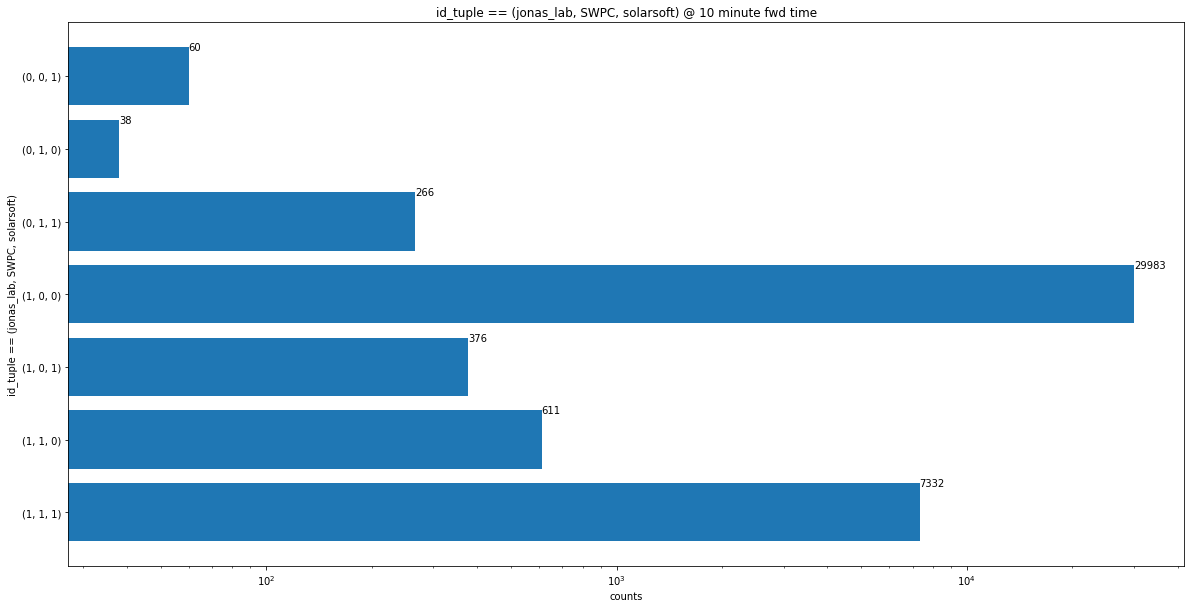

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111)


# Example data
id_tuple = stat_df.id_tuple.to_list()
y_pos = np.arange(len(id_tuple))
counts = stat_df.counts.to_list()
# error = np.random.rand(len(people))



hbars = ax.barh(y_pos, counts, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(id_tuple)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('counts')
ax.set_ylabel('id_tuple == (jonas_lab, SWPC, solarsoft)')
ax.set_title('id_tuple == (jonas_lab, SWPC, solarsoft) @ {} minute fwd time'.format(minutes_per_agg))

for bar in hbars:
    print(bar.get_y())
    ax.text(bar.get_width(), bar.get_y(), s = bar.get_width(), va = 'center')

ax.set_xscale('log')

-0.4
0.6
1.6
2.6
3.6
4.6
5.6


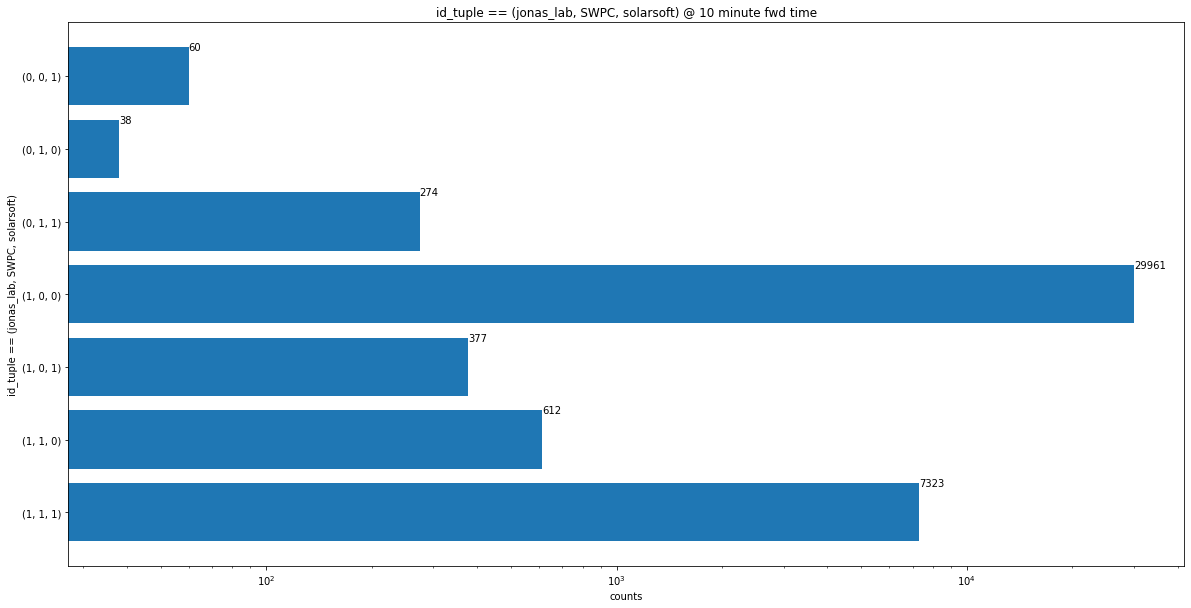

In [85]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111)


# Example data
id_tuple = stat_df.id_tuple.to_list()
y_pos = np.arange(len(id_tuple))
counts = stat_df.counts.to_list()
# error = np.random.rand(len(people))



hbars = ax.barh(y_pos, counts, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(id_tuple)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('counts')
ax.set_ylabel('id_tuple == (jonas_lab, SWPC, solarsoft)')
ax.set_title('id_tuple == (jonas_lab, SWPC, solarsoft) @ {} minute fwd time'.format(minutes_per_agg))

for bar in hbars:
    print(bar.get_y())
    ax.text(bar.get_width(), bar.get_y(), s = bar.get_width(), va = 'center')

ax.set_xscale('log')

In [111]:
904-308

596

In [116]:
595+25+1+19+1

641

In [117]:
from matplotlib_venn import venn3, venn3_circles

def make_ven_diagram(axis, data):

    v3 = venn3(subsets = {'100':70, '010':70, '110':500,'001':1000, '101':500, '011':700, '111':000}, set_labels = ('', '', ''), ax = axis)

    v3.get_patch_by_id('100').set_color('red')
    v3.get_patch_by_id('010').set_color('yellow')
    v3.get_patch_by_id('001').set_color('blue')
    v3.get_patch_by_id('110').set_color('orange')
    v3.get_patch_by_id('101').set_color('purple')
    v3.get_patch_by_id('011').set_color('green')
    v3.get_patch_by_id('111').set_color('grey')

    

    v3.get_label_by_id('100').set_text('38:\n  SWPC')
    v3.get_label_by_id('010').set_text('60:\n SolarSoft')
    v3.get_label_by_id('001').set_text('29,961:\n ALEXIS')
    v3.get_label_by_id('110').set_text('274:\n SolarSoft \n & SWPC')
    v3.get_label_by_id('101').set_text('612:\n ALEXIS \n & \n SWPC ')
    v3.get_label_by_id('011').set_text('377:\n ALEXIS \n & \n SolarSoft')
    v3.get_label_by_id('111').set_text('7323:\n  SolarSoft & \n SWPC & ALEXIS')
    
    v3.get_label_by_id('100').set_fontsize(1000)
    
    for text in v3.subset_labels:
        text.set_fontsize(17)


    # (1,0,0): X:4 ; M:229 ; C:29728 #
    # (0,1,0): X:0 ; M: 7; C:31 # done
    # (0,0,1): X:0 ; M:12 ; C:48 # done
    # (1,1,0): X:7; M:67 ; C:538# done
    # (1,0,1): X:1 ; M: 15; C:361 # done
    # (1,1,1): X:46 ; M:641 ; C:6637 # done
    # (0,1,1): X: 1 ; M: 19 ; C: 254 # done

    plt.annotate('C-Class: 31 \nM-Class: 7 \nX-Class: 0', xy=v3.get_label_by_id('100').get_position() - np.array([0.05, 0.0]), 
                 xytext=(-150, 100),
                ha='left', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3',color='gray', linewidth=4),fontsize=20)

    plt.annotate('C-Class: 254 \n M-Class: 19 \nX-Class: 1', xy=v3.get_label_by_id('110').get_position() + np.array([0., 0.05]), xytext=(50,110),
                ha='left', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3',color='gray', linewidth=4),fontsize=20)

    plt.annotate('C-Class: 48 \nM-Class: 12 \nX-Class: 0', xy=v3.get_label_by_id('010').get_position() + np.array([0., 0.05]), xytext=(50,50),
                ha='left', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3',color='gray', linewidth=4),fontsize=20)

    plt.annotate('C-Class: 6,637 \nM-Class: 641 \nX-Class: 46', xy=v3.get_label_by_id('111').get_position() + np.array([0., 0.05]), xytext=(350,75),
                ha='left', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3',color='gray', linewidth=4),fontsize=20)

    plt.annotate('C-Class: 361 \nM-Class: 15 \nX-Class: 1', xy=v3.get_label_by_id('011').get_position() + np.array([0.05, 0.05]), xytext=(200,10),
                ha='left', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3',color='gray', linewidth=4),fontsize=20)

    plt.annotate('C-Class: 538 \nM-Class: 67 \nX-Class: 7', xy=v3.get_label_by_id('101').get_position() - np.array([0.05, 0.05]), xytext=(-235,0),
                ha='left', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3',color='gray', linewidth=4),fontsize=20)

    plt.annotate('C-Class: 29,728 \nM-Class: 229 \nX-Class: 4', xy=v3.get_label_by_id('001').get_position() - np.array([0., 0.05]), xytext=(-450,-75),
                ha='left', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3',color='gray', linewidth=4),fontsize=20)


    # Add annotation
    plt.annotate('Not to Scale', xy=(.90, 0.85), xycoords='axes fraction', fontsize=25, color='red')

    plt.tight_layout()

    plt.savefig(f'{dataconfig.DATA_DIR_PRODUCTS}/venn_diagram.jpg', dpi = 300)

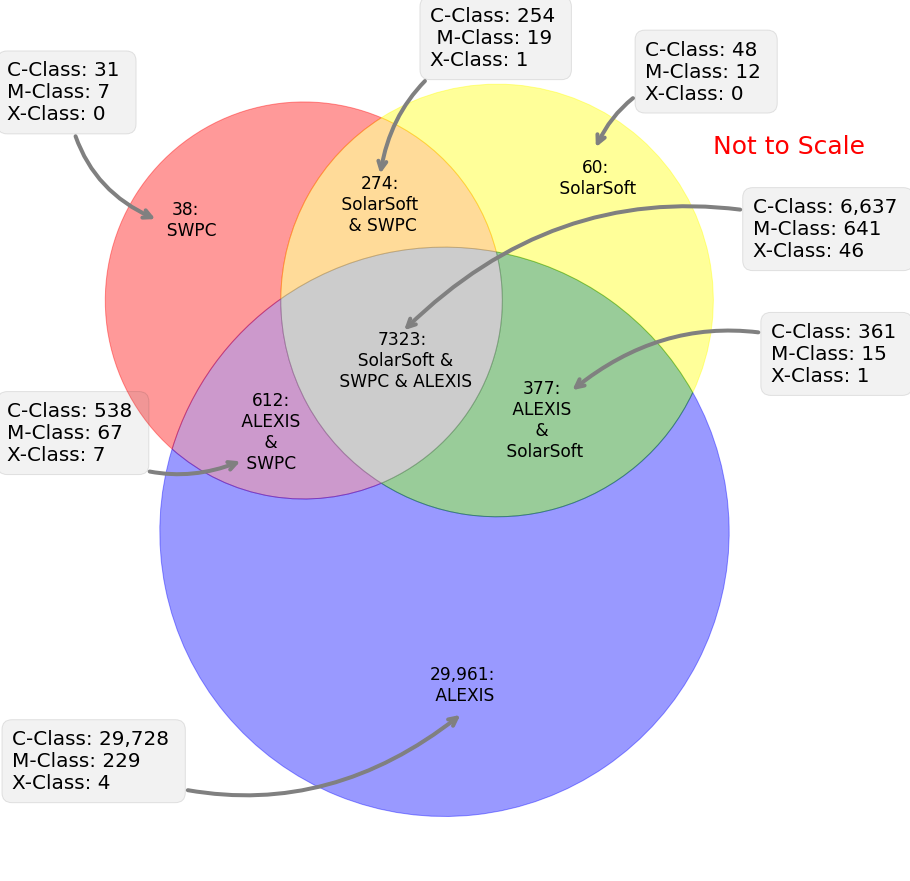

In [118]:
fig = plt.figure(figsize = (13,13))
ax = fig.add_subplot(111)

make_ven_diagram(ax, stat_df)

# under this is experimental work

In [81]:
255+19+1

275

In [ ]:
# no_duplicates = pd.concat([ss_flares_no_dup,swpc_flares_no_dup]).sort_values(by = 'peak_time').reset_index(drop = True)

# no_duplicates

In [179]:
ss_flares.drop_duplicates()

,event_date,start_time,peak_time,end_time,goes_class,goes_letter,goes_number,AR_num,hgs_x,hgs_y,...,hgc_y,hpc_x,hpc_y,event_type,telescope_used,id_institute,id_team,search_instrument,search_channel,noposition
1,2010-05-01,2010-05-01 01:34:00+00:00,2010-05-01 01:39:00+00:00,2010-05-01 01:43:00+00:00,C5.7,C,5.7,0.0,-81.0,24.0,...,24.0,-859.938000,396.548400,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
40,2010-05-04,2010-05-04 16:15:00+00:00,2010-05-04 16:29:00+00:00,2010-05-04 16:29:00+00:00,C3.6,C,3.6,0.0,23.0,41.0,...,41.0,281.485800,668.976000,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
46,2010-05-05,2010-05-05 07:09:00+00:00,2010-05-05 07:16:00+00:00,2010-05-05 07:16:00+00:00,C2.3,C,2.3,1069.0,31.0,41.0,...,41.0,370.899000,665.040000,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
54,2010-05-05,2010-05-05 11:37:00+00:00,2010-05-05 11:52:00+00:00,2010-05-05 11:58:00+00:00,C8.9,C,8.9,1069.0,34.0,41.0,...,41.0,402.639000,663.432000,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
60,2010-05-05,2010-05-05 17:13:00+00:00,2010-05-05 17:19:00+00:00,2010-05-05 17:22:00+00:00,M1.2,M,1.2,0.0,5.0,21.0,...,21.0,77.740200,399.115800,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124521,2020-11-28,2020-11-28 22:59:00+00:00,2020-11-28 23:18:00+00:00,2020-11-28 23:32:00+00:00,C3.1,C,3.1,2786.0,-16.0,-20.0,...,-20.0,-252.887832,-351.030078,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
124528,2020-11-29,2020-11-29 00:50:00+00:00,2020-11-29 01:16:00+00:00,2020-11-29 01:48:00+00:00,C1.3,C,1.3,2786.0,-15.0,-18.0,...,-18.0,-240.350736,-318.982734,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
124529,2020-11-29,2020-11-29 00:59:00+00:00,2020-11-29 01:16:00+00:00,2020-11-29 02:43:00+00:00,C1.3,C,1.3,2786.0,-15.0,-18.0,...,-18.0,-240.351006,-318.970812,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
124530,2020-11-29,2020-11-29 11:24:00+00:00,2020-11-29 11:44:00+00:00,2020-11-29 12:03:00+00:00,C1.6,C,1.6,2786.0,-11.0,-20.0,...,-20.0,-175.092630,-350.437218,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0


In [175]:
goes_flares = hek_flares[(hek_flares['id_team'] == 'SWPC') & (hek_flares['goes_class'] > 'C')].reset_index(drop= True)

solarsoft_flares = hek_flares[(hek_flares['id_team'] == 'SolarSoft') & (hek_flares['goes_class'] > 'C')].reset_index(drop= True)

zero_cross = merged_zerocross_df[(merged_zerocross_df['resampled_value'] > flare_class_dict_query['C'])].reset_index(drop= True)


In [177]:
goes_flares

,event_date,start_time,peak_time,end_time,goes_class,goes_letter,goes_number,AR_num,hgs_x,hgs_y,...,hpc_x,hpc_y,hpc_bbox_poly,event_type,telescope_used,id_institute,id_team,search_instrument,search_channel,noposition
0,2010-05-01,2010-05-01 01:34:00+00:00,2010-05-01 01:39:00+00:00,2010-05-01 01:43:00+00:00,C5.7,C,5.7,11067.0,-73.0,23.0,...,-838.854000,390.063600,"[[-844.122, 381.936], [-839.688, 383.0358], [-...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,0
1,2010-05-04,2010-05-04 16:15:00+00:00,2010-05-04 16:29:00+00:00,2010-05-04 16:34:00+00:00,C3.6,C,3.6,11069.0,23.0,41.0,...,281.286000,668.496000,"[[277.5822, 662.724], [289.2288, 662.382], [28...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,0
2,2010-05-05,2010-05-05 07:09:00+00:00,2010-05-05 07:16:00+00:00,2010-05-05 07:20:00+00:00,C2.3,C,2.3,11069.0,0.0,0.0,...,0.000000,62.479200,"[[8.3e-05, -949.11], [-8.3e-05, -949.11], [0.0...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,1
3,2010-05-05,2010-05-05 11:37:00+00:00,2010-05-05 11:52:00+00:00,2010-05-05 11:58:00+00:00,C8.8,C,8.8,11069.0,0.0,0.0,...,0.000000,62.151600,"[[8.3e-05, -949.086], [-8.3e-05, -949.086], [0...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,1
4,2010-05-05,2010-05-05 17:13:00+00:00,2010-05-05 17:19:00+00:00,2010-05-05 17:22:00+00:00,M1.2,M,1.2,11069.0,37.0,42.0,...,426.295800,673.032000,"[[424.6554, 667.398], [434.5908, 666.888], [42...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8371,2020-11-28,2020-11-28 17:29:00+00:00,2020-11-28 17:38:00+00:00,2020-11-28 17:59:00+00:00,C1.2,C,1.2,12786.0,-22.0,-15.0,...,-353.258676,-270.086262,"[[-360.008316, -278.193462], [-344.795262, -27...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,0
8372,2020-11-28,2020-11-28 22:59:00+00:00,2020-11-28 23:18:00+00:00,2020-11-28 23:32:00+00:00,C3.1,C,3.1,12786.0,-16.0,-19.0,...,-254.462832,-335.086110,"[[-261.392916, -343.023846], [-245.957562, -34...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,0
8373,2020-11-29,2020-11-29 00:50:00+00:00,2020-11-29 01:16:00+00:00,2020-11-29 01:48:00+00:00,C1.3,C,1.3,12786.0,0.0,0.0,...,0.000000,-18.844432,"[[-1.696518, -971.95674], [1.696518, -971.9567...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,1
8374,2020-11-29,2020-11-29 11:24:00+00:00,2020-11-29 11:44:00+00:00,2020-11-29 12:03:00+00:00,C1.6,C,1.6,12786.0,0.0,0.0,...,0.000000,-17.897306,"[[-1.696655, -972.05256], [1.696655, -972.0525...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,1


In [76]:
hek_flares[hek_flares.goes_letter >= 'C'].id_team.value_counts()

SolarSoft    9038
SWPC         8376
SEC            26
Annotator       4
Name: id_team, dtype: int64

# There are many teams, but only SWPC and SolarSoft have data above C-Class

In [77]:
# alexis_search = hek_flares[hek_flares.goes_letter >= 'C']

In [78]:
# hek_flares.id_team.value_counts()

In [79]:
ss_flares = hek_flares[(hek_flares.id_team =='SolarSoft') & (hek_flares.goes_letter >= 'C') &  (hek_flares.search_instrument == 'AIA')][['event_date', 'start_time', 'peak_time', 'end_time', 'goes_class',
       'goes_letter', 'goes_number', 'AR_num', 'hgs_x', 'hgs_y', 'hgc_x', 'hgc_y', 'hpc_x', 'hpc_y', 'event_type', 'telescope_used', 'id_institute',
       'id_team', 'search_instrument', 'search_channel', 'noposition']]
ss_flares.goes_letter.value_counts(), len(ss_flares)


(C    8095
 M     776
 X      52
 Name: goes_letter, dtype: int64,
 8923)

In [81]:
ss_flares.drop_duplicates().goes_letter.value_counts(), len(ss_flares.drop_duplicates())

(C    7952
 M     751
 X      52
 Name: goes_letter, dtype: int64,
 8755)

In [82]:
ss_flares_no_dup = ss_flares.drop_duplicates()

In [83]:
swpc_flares = hek_flares[(hek_flares.id_team =='SWPC')& (hek_flares.goes_letter >= 'C') ][['event_date', 'start_time', 'peak_time', 'end_time', 'goes_class',
       'goes_letter', 'goes_number', 'AR_num', 'hgs_x', 'hgs_y', 'hgc_x', 'hgc_y', 'hpc_x', 'hpc_y', 'event_type', 'telescope_used', 'id_institute',
       'id_team', 'search_instrument', 'search_channel', 'noposition']]
swpc_flares.goes_letter.value_counts()

C    7603
M     724
X      49
Name: goes_letter, dtype: int64

In [84]:
swpc_flares.drop_duplicates().goes_letter.value_counts(),len(swpc_flares.drop_duplicates())

(C    7601
 M     724
 X      49
 Name: goes_letter, dtype: int64,
 8374)

In [143]:
swpc_flares_no_dup = swpc_flares.drop_duplicates()

In [147]:
no_duplicates = pd.concat([ss_flares_no_dup,swpc_flares_no_dup]).sort_values(by = 'peak_time').reset_index(drop = True)

no_duplicates

,event_date,start_time,peak_time,end_time,goes_class,goes_letter,goes_number,AR_num,hgs_x,hgs_y,...,hgc_y,hpc_x,hpc_y,event_type,telescope_used,id_institute,id_team,search_instrument,search_channel,noposition
0,2010-05-01,2010-05-01 01:34:00+00:00,2010-05-01 01:39:00+00:00,2010-05-01 01:43:00+00:00,C5.7,C,5.7,0.0,-81.0,24.0,...,24.0,-859.938000,396.548400,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
1,2010-05-01,2010-05-01 01:34:00+00:00,2010-05-01 01:39:00+00:00,2010-05-01 01:43:00+00:00,C5.7,C,5.7,11067.0,-73.0,23.0,...,23.0,-838.854000,390.063600,FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,0
2,2010-05-04,2010-05-04 16:15:00+00:00,2010-05-04 16:29:00+00:00,2010-05-04 16:29:00+00:00,C3.6,C,3.6,0.0,23.0,41.0,...,41.0,281.485800,668.976000,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
3,2010-05-04,2010-05-04 16:15:00+00:00,2010-05-04 16:29:00+00:00,2010-05-04 16:34:00+00:00,C3.6,C,3.6,11069.0,23.0,41.0,...,41.0,281.286000,668.496000,FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,0
4,2010-05-05,2010-05-05 07:09:00+00:00,2010-05-05 07:16:00+00:00,2010-05-05 07:16:00+00:00,C2.3,C,2.3,1069.0,31.0,41.0,...,41.0,370.899000,665.040000,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17124,2020-11-29,2020-11-29 00:59:00+00:00,2020-11-29 01:16:00+00:00,2020-11-29 02:43:00+00:00,C1.3,C,1.3,2786.0,-15.0,-18.0,...,-18.0,-240.351006,-318.970812,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
17125,2020-11-29,2020-11-29 11:24:00+00:00,2020-11-29 11:44:00+00:00,2020-11-29 12:03:00+00:00,C1.6,C,1.6,2786.0,-11.0,-20.0,...,-20.0,-175.092630,-350.437218,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
17126,2020-11-29,2020-11-29 11:24:00+00:00,2020-11-29 11:44:00+00:00,2020-11-29 12:03:00+00:00,C1.6,C,1.6,12786.0,0.0,0.0,...,0.0,0.000000,-17.897306,FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,1
17127,2020-11-29,2020-11-29 12:34:00+00:00,2020-11-29 13:11:00+00:00,2020-11-29 13:41:00+00:00,M4.4,M,4.4,0.0,-89.0,-23.0,...,-23.0,-894.917700,-380.151432,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0


In [151]:
all_repeated_peak_times = no_duplicates[no_duplicates.duplicated(subset='peak_time')].peak_time.to_list()

out_dict_list = []

for repeated_peaktime in all_repeated_peak_times:

    mask = no_duplicates[no_duplicates.peak_time == repeated_peaktime].sort_values(by = 'id_team')
    
    out_dict_list.append({'repeated_peaktime': repeated_peaktime, 'teams': np.str(mask.id_team.to_list()), 'number': len(mask.id_team.to_list()), 'index_list':mask.index.to_list() })

In [158]:
pd.DataFrame(out_dict_list).teams.value_counts().keys

<bound method Series.keys of ['SWPC', 'SolarSoft']                              6794
['SWPC', 'SolarSoft', 'SolarSoft']                  776
['SWPC', 'SWPC', 'SolarSoft', 'SolarSoft']           24
['SolarSoft', 'SolarSoft']                           20
['SWPC', 'SolarSoft', 'SolarSoft', 'SolarSoft']      18
['SWPC', 'SWPC', 'SolarSoft']                        16
['SolarSoft', 'SolarSoft', 'SolarSoft']               6
['SWPC', 'SWPC', 'SWPC', 'SolarSoft']                 3
['SWPC', 'SWPC']                                      3
Name: teams, dtype: int64>

In [165]:
same_peaktimes = pd.DataFrame(out_dict_list)
same_peaktimes[same_peaktimes.teams == np.str(['SWPC','SWPC', 'SolarSoft', 'SolarSoft'])]

,repeated_peaktime,teams,number,index_list
165,2011-03-05 09:08:00+00:00,"['SWPC', 'SWPC', 'SolarSoft', 'SolarSoft']",4,"[449, 450, 447, 448]"
166,2011-03-05 09:08:00+00:00,"['SWPC', 'SWPC', 'SolarSoft', 'SolarSoft']",4,"[449, 450, 447, 448]"
167,2011-03-05 09:08:00+00:00,"['SWPC', 'SWPC', 'SolarSoft', 'SolarSoft']",4,"[449, 450, 447, 448]"
2128,2012-09-11 09:32:00+00:00,"['SWPC', 'SWPC', 'SolarSoft', 'SolarSoft']",4,"[5013, 5015, 5014, 5016]"
2129,2012-09-11 09:32:00+00:00,"['SWPC', 'SWPC', 'SolarSoft', 'SolarSoft']",4,"[5013, 5015, 5014, 5016]"
2130,2012-09-11 09:32:00+00:00,"['SWPC', 'SWPC', 'SolarSoft', 'SolarSoft']",4,"[5013, 5015, 5014, 5016]"
2165,2012-09-29 07:53:00+00:00,"['SWPC', 'SWPC', 'SolarSoft', 'SolarSoft']",4,"[5084, 5085, 5086, 5087]"
2166,2012-09-29 07:53:00+00:00,"['SWPC', 'SWPC', 'SolarSoft', 'SolarSoft']",4,"[5084, 5085, 5086, 5087]"
2167,2012-09-29 07:53:00+00:00,"['SWPC', 'SWPC', 'SolarSoft', 'SolarSoft']",4,"[5084, 5085, 5086, 5087]"
3303,2013-10-21 20:34:00+00:00,"['SWPC', 'SWPC', 'SolarSoft', 'SolarSoft']",4,"[7659, 7660, 7657, 7658]"


In [168]:
no_duplicates.iloc[447:451]

,event_date,start_time,peak_time,end_time,goes_class,goes_letter,goes_number,AR_num,hgs_x,hgs_y,...,hgc_y,hpc_x,hpc_y,event_type,telescope_used,id_institute,id_team,search_instrument,search_channel,noposition
447,2011-03-05,2011-03-05 09:01:00+00:00,2011-03-05 09:08:00+00:00,2011-03-05 09:15:00+00:00,C2.2,C,2.2,0.0,48.0,-18.0,...,-18.0,685.55286,-219.471282,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
448,2011-03-05,2011-03-05 05:41:00+00:00,2011-03-05 09:08:00+00:00,2011-03-05 09:18:00+00:00,C2.2,C,2.2,0.0,47.0,-17.0,...,-17.0,678.46590,-201.544680,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
449,2011-03-05,2011-03-05 09:01:00+00:00,2011-03-05 09:08:00+00:00,2011-03-05 09:15:00+00:00,C2.2,C,2.2,11165.0,0.0,0.0,...,0.0,0.00000,122.556000,FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,1
450,2011-03-05,2011-03-05 05:41:00+00:00,2011-03-05 09:08:00+00:00,2011-03-05 09:18:00+00:00,C2.2,C,2.2,0.0,0.0,0.0,...,0.0,0.00000,122.551800,FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,1


In [85]:
ss_index = ss_flares.drop_duplicates().index.to_list()
swpc_index = swpc_flares.drop_duplicates().index.to_list()

# ss_index.to_list()
keep_indexes_after_drop_duplicates = np.concatenate([ss_index, swpc_index])
keep_indexes_after_drop_duplicates

array([     1,     40,     46, ..., 124527, 124531, 124535])

In [136]:
hek_after_drop_duplicates = hek_flares.iloc[keep_indexes_after_drop_duplicates].reset_index(drop = True)
hek_after_drop_duplicates

,event_date,start_time,peak_time,end_time,goes_class,goes_letter,goes_number,AR_num,hgs_x,hgs_y,...,hpc_x,hpc_y,hpc_bbox_poly,event_type,telescope_used,id_institute,id_team,search_instrument,search_channel,noposition
0,2010-05-01,2010-05-01 01:34:00+00:00,2010-05-01 01:39:00+00:00,2010-05-01 01:43:00+00:00,C5.7,C,5.7,0.0,-81.0,24.0,...,-859.938000,396.548400,"[[16.69878, 86.4576], [16.69878, 86.4576], [16...",FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
1,2010-05-04,2010-05-04 16:15:00+00:00,2010-05-04 16:29:00+00:00,2010-05-04 16:29:00+00:00,C3.6,C,3.6,0.0,23.0,41.0,...,281.485800,668.976000,"[[16.68342, 80.2428], [16.68342, 80.2428], [16...",FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
2,2010-05-05,2010-05-05 07:09:00+00:00,2010-05-05 07:16:00+00:00,2010-05-05 07:16:00+00:00,C2.3,C,2.3,1069.0,31.0,41.0,...,370.899000,665.040000,"[[16.68084, 79.152], [16.68084, 79.152], [16.6...",FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
3,2010-05-05,2010-05-05 11:37:00+00:00,2010-05-05 11:52:00+00:00,2010-05-05 11:58:00+00:00,C8.9,C,8.9,1069.0,34.0,41.0,...,402.639000,663.432000,"[[16.68006, 78.8238], [16.68006, 78.8238], [16...",FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
4,2010-05-05,2010-05-05 17:13:00+00:00,2010-05-05 17:19:00+00:00,2010-05-05 17:22:00+00:00,M1.2,M,1.2,0.0,5.0,21.0,...,77.740200,399.115800,"[[16.6791, 78.4116], [16.6791, 78.4116], [16.6...",FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17124,2020-11-28,2020-11-28 17:29:00+00:00,2020-11-28 17:38:00+00:00,2020-11-28 17:59:00+00:00,C1.2,C,1.2,12786.0,-22.0,-15.0,...,-353.258676,-270.086262,"[[-360.008316, -278.193462], [-344.795262, -27...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,0
17125,2020-11-28,2020-11-28 22:59:00+00:00,2020-11-28 23:18:00+00:00,2020-11-28 23:32:00+00:00,C3.1,C,3.1,12786.0,-16.0,-19.0,...,-254.462832,-335.086110,"[[-261.392916, -343.023846], [-245.957562, -34...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,0
17126,2020-11-29,2020-11-29 00:50:00+00:00,2020-11-29 01:16:00+00:00,2020-11-29 01:48:00+00:00,C1.3,C,1.3,12786.0,0.0,0.0,...,0.000000,-18.844432,"[[-1.696518, -971.95674], [1.696518, -971.9567...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,1
17127,2020-11-29,2020-11-29 11:24:00+00:00,2020-11-29 11:44:00+00:00,2020-11-29 12:03:00+00:00,C1.6,C,1.6,12786.0,0.0,0.0,...,0.000000,-17.897306,"[[-1.696655, -972.05256], [1.696655, -972.0525...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,1


In [131]:
hek_after_drop_duplicates.id_team.value_counts()

SolarSoft    8755
SWPC         8374
Name: id_team, dtype: int64

In [90]:
alexis_search = hek_after_drop_duplicates.copy()
alexis_search.id_team.value_counts()

SolarSoft    8755
SWPC         8374
Name: id_team, dtype: int64

In [91]:
alexis_search.id_team.value_counts()

SolarSoft    8755
SWPC         8374
Name: id_team, dtype: int64

In [139]:
all_repeated_peak_times = alexis_search[alexis_search.duplicated(subset='peak_time')].peak_time.to_list()

out_dict_list = []

for repeated_peaktime in all_repeated_peak_times:

    mask = alexis_search[alexis_search.peak_time == repeated_peaktime]
    
    out_dict_list.append({'repeated_peaktime': repeated_peaktime, 'teams': np.str(mask.id_team.to_list()), 'number': len(mask.id_team.to_list()), 'index_list':mask.index.to_list() })

In [140]:
repeated_date_time_df = pd.DataFrame(out_dict_list)

repeated_date_time_df


,repeated_peaktime,teams,number,index_list
0,2010-06-12 04:06:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[8, 9, 8765]"
1,2010-06-13 05:39:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[12, 13, 8767]"
2,2010-08-07 18:24:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[32, 33, 8787]"
3,2010-09-21 07:53:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[46, 47, 8800]"
4,2010-10-19 10:14:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[58, 59, 8811]"
...,...,...,...,...
7655,2020-11-28 17:38:00+00:00,"['SolarSoft', 'SWPC']",2,"[8749, 17124]"
7656,2020-11-28 23:18:00+00:00,"['SolarSoft', 'SWPC']",2,"[8750, 17125]"
7657,2020-11-29 01:16:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[8751, 8752, 17126]"
7658,2020-11-29 11:44:00+00:00,"['SolarSoft', 'SWPC']",2,"[8753, 17127]"


In [141]:
keep_index_list_from_two_team_same_peak = np.array(repeated_date_time_df[repeated_date_time_df.teams == "['SolarSoft', 'SWPC']"].index_list.to_list()).flatten()

np.sum(repeated_date_time_df.teams.value_counts().values)

7660

In [142]:
repeated_date_time_df.teams.value_counts()

['SolarSoft', 'SWPC']                              6794
['SolarSoft', 'SolarSoft', 'SWPC']                  776
['SolarSoft', 'SolarSoft', 'SWPC', 'SWPC']           24
['SolarSoft', 'SolarSoft']                           20
['SolarSoft', 'SolarSoft', 'SolarSoft', 'SWPC']      18
['SolarSoft', 'SWPC', 'SWPC']                        16
['SolarSoft', 'SolarSoft', 'SolarSoft']               6
['SWPC', 'SWPC']                                      3
['SolarSoft', 'SWPC', 'SWPC', 'SWPC']                 3
Name: teams, dtype: int64

In [95]:
after_drop_dup_and_two_team_same_peak = alexis_search.drop(index = keep_index_list_from_two_team_same_peak)[['start_time', 'peak_time', 'end_time',
       'goes_letter', 'goes_number', 'AR_num', 'hgs_x', 'hgs_y', 'hgc_x', 'hgc_y', 'hpc_x', 'hpc_y', 'event_type', 'telescope_used', 'id_institute',
       'id_team', 'search_instrument', 'noposition']]

after_drop_dup_and_two_team_same_peak

,start_time,peak_time,end_time,goes_letter,goes_number,AR_num,hgs_x,hgs_y,hgc_x,hgc_y,hpc_x,hpc_y,event_type,telescope_used,id_institute,id_team,search_instrument,noposition
5,2010-05-07 07:29:00+00:00,2010-05-07 07:41:00+00:00,2010-05-07 07:42:00+00:00,C,2.0,1069.0,54.0,40.0,-138.212510,40.0,590.5332,637.794000,FL,SDO,LMSAL,SolarSoft,AIA,0
8,2010-06-12 03:57:00+00:00,2010-06-12 04:06:00+00:00,2010-06-12 04:17:00+00:00,C,1.0,1081.0,50.0,23.0,103.456461,23.0,668.2140,363.837600,FL,SDO,LMSAL,SolarSoft,AIA,0
9,2010-06-12 03:57:00+00:00,2010-06-12 04:06:00+00:00,2010-06-12 04:06:00+00:00,C,1.0,1077.0,50.0,23.0,103.456461,23.0,668.2140,363.837600,FL,SDO,LMSAL,SolarSoft,AIA,0
10,2010-06-12 09:02:00+00:00,2010-06-12 09:16:00+00:00,2010-06-12 09:17:00+00:00,C,6.1,1081.0,52.0,23.0,102.652958,23.0,687.2820,363.817800,FL,SDO,LMSAL,SolarSoft,AIA,0
12,2010-06-13 05:30:00+00:00,2010-06-13 05:39:00+00:00,2010-06-13 05:39:00+00:00,M,1.0,1079.0,82.0,-24.0,121.365342,-24.0,855.3120,-386.158200,FL,SDO,LMSAL,SolarSoft,AIA,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17055,2020-05-29 10:41:00+00:00,2020-05-29 10:46:00+00:00,2020-05-29 10:50:00+00:00,C,9.3,0.0,0.0,0.0,-100.158870,0.0,0.0000,15.696484,FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,1
17058,2020-08-15 06:32:00+00:00,2020-08-15 06:47:00+00:00,2020-08-15 07:00:00+00:00,C,2.0,12770.0,70.0,26.0,20.057350,26.0,801.0219,379.120548,FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,0
17107,2020-11-20 18:10:00+00:00,2020-11-20 18:45:00+00:00,2020-11-20 19:19:00+00:00,C,1.0,0.0,0.0,0.0,103.577940,0.0,0.0000,-36.320075,FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,1
17119,2020-11-26 19:20:00+00:00,2020-11-26 21:23:00+00:00,2020-11-26 23:53:00+00:00,C,2.6,0.0,0.0,0.0,23.853452,0.0,0.0000,-23.616502,FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,1


In [22]:
ss_2_w_sw_1 = repeated_date_time_df[repeated_date_time_df.teams == "['SolarSoft', 'SolarSoft', 'SWPC']"]
ss_2_w_sw_1

,repeated_peaktime,teams,number,index_list
0,2010-06-12 04:06:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[8, 9, 8765]"
1,2010-06-13 05:39:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[12, 13, 8767]"
2,2010-08-07 18:24:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[32, 33, 8787]"
3,2010-09-21 07:53:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[46, 47, 8800]"
4,2010-10-19 10:14:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[58, 59, 8811]"
...,...,...,...,...
7563,2019-03-21 03:00:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[8645, 8646, 17030]"
7587,2020-05-29 10:46:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[8671, 8672, 17055]"
7590,2020-08-15 06:47:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[8675, 8676, 17058]"
7650,2020-11-26 21:23:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[8743, 8744, 17119]"


In [96]:
mask = after_drop_dup_and_two_team_same_peak[after_drop_dup_and_two_team_same_peak.peak_time == ss_2_w_sw_1.iloc[753].repeated_peaktime]

ss_compare = mask[mask.id_team == 'SolarSoft'][['start_time', 'peak_time', 'end_time',
       'goes_letter', 'goes_number', 'AR_num', 'hgs_x', 'hgs_y', 'hgc_x', 'hgc_y', 'hpc_x', 'hpc_y']]
sw_compare = mask[mask.id_team == 'SWPC'][['start_time', 'peak_time', 'end_time',
       'goes_letter', 'goes_number', 'AR_num', 'hgs_x', 'hgs_y', 'hgc_x', 'hgc_y', 'hpc_x', 'hpc_y']]

In [134]:
mask

,peak_time,id_team
82672,2019-05-15 19:23:58.338000128+00:00,ALEXIS
82673,2019-05-15 19:24:00+00:00,SWPC
82674,2019-05-15 19:24:00+00:00,SolarSoft
82675,2019-05-15 19:24:00.660999936+00:00,ALEXIS


In [97]:
ss_compare

compare_df = ss_compare.iloc[1].compare(ss_compare.iloc[0]).reset_index().rename(columns={'index':'metadata'})

compare_df['difference'] = compare_df['other'] - compare_df['self']

# compare_df['edit'] = []

compare_df

,metadata,self,other,difference
0,start_time,2016-07-20 22:03:00+00:00,2016-07-20 21:58:00+00:00,-1 days +23:55:00
1,end_time,2016-07-20 22:54:00+00:00,2016-07-20 23:18:00+00:00,0 days 00:24:00
2,goes_number,4.6,4.7,0.1
3,hgc_x,170.77761,170.82355,0.04594
4,hpc_x,632.14578,632.14566,-0.00012
5,hpc_y,5.849538,5.853338,0.0038


In [98]:
compare_df = ss_compare.iloc[0].compare(sw_compare.iloc[0]).reset_index().rename(columns={'index':'metadata'})

compare_df['difference'] = compare_df['other'] - compare_df['self']

compare_df.self.iloc[0].dtype

AttributeError: 'Timestamp' object has no attribute 'dtype'

In [99]:
alexis_search[alexis_search.peak_time == pd.Timestamp('2013-12-22T09:32:00.00', tz = 'utc')]

,event_date,start_time,peak_time,end_time,goes_class,goes_letter,goes_number,AR_num,hgs_x,hgs_y,...,hpc_x,hpc_y,hpc_bbox_poly,event_type,telescope_used,id_institute,id_team,search_instrument,search_channel,noposition
4463,2013-12-22,2013-12-22 09:03:00+00:00,2013-12-22 09:32:00+00:00,2013-12-22 09:57:00+00:00,C6.4,C,6.4,1934.0,-47.0,-17.0,...,-683.96472,-265.330218,"[[17.092121, 48.473329], [17.092121, 48.473329...",FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
12899,2013-12-22,2013-12-22 09:03:00+00:00,2013-12-22 09:32:00+00:00,2013-12-22 09:57:00+00:00,C6.4,C,6.4,11934.0,-47.0,-14.0,...,-693.99600,-215.727600,"[[-698.046, -224.2278], [-686.814, -223.8534],...",FL,GOES,"U.S. Dept. of Commerce, NOAA, Space Weather Pr...",SWPC,GOES,XRA,0


In [28]:
repeated_date_time_df

,repeated_peaktime,teams,number,index_list
0,2010-06-12 04:06:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[8, 9, 8765]"
1,2010-06-13 05:39:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[12, 13, 8767]"
2,2010-08-07 18:24:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[32, 33, 8787]"
3,2010-09-21 07:53:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[46, 47, 8800]"
4,2010-10-19 10:14:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[58, 59, 8811]"
...,...,...,...,...
7655,2020-11-28 17:38:00+00:00,"['SolarSoft', 'SWPC']",2,"[8749, 17124]"
7656,2020-11-28 23:18:00+00:00,"['SolarSoft', 'SWPC']",2,"[8750, 17125]"
7657,2020-11-29 01:16:00+00:00,"['SolarSoft', 'SolarSoft', 'SWPC']",3,"[8751, 8752, 17126]"
7658,2020-11-29 11:44:00+00:00,"['SolarSoft', 'SWPC']",2,"[8753, 17127]"


In [29]:
still_needs_work_1 = alexis_search.drop(keep_index_list)
still_needs_work_1.id_team.value_counts()

NameError: name 'keep_index_list' is not defined

In [30]:
compare_this = still_needs_work_1[still_needs_work_1.peak_time == repeated_date_time_df.iloc[1].repeated_peaktime][['start_time', 'peak_time', 'end_time',
       'goes_letter', 'goes_number', 'AR_num', 'hgs_x', 'hgs_y', 'hgc_x', 'hgc_y', 'hpc_x', 'hpc_y', 'event_type', 'telescope_used', 'id_institute',
       'id_team', 'search_instrument', 'noposition']]
compare_this

NameError: name 'still_needs_work_1' is not defined

In [31]:
ss_compare = compare_this[compare_this.id_team == 'SolarSoft'][['start_time', 'peak_time', 'end_time',
       'goes_letter', 'goes_number', 'AR_num', 'hgs_x', 'hgs_y', 'hgc_x', 'hgc_y', 'hpc_x', 'hpc_y']]
sw_compare = compare_this[compare_this.id_team == 'SWPC'][['start_time', 'peak_time', 'end_time',
       'goes_letter', 'goes_number', 'AR_num', 'hgs_x', 'hgs_y', 'hgc_x', 'hgc_y', 'hpc_x', 'hpc_y']]

print(len(ss_compare), len(sw_compare))

compare_df = ss_compare.iloc[0].compare(sw_compare.iloc[0]).reset_index().rename(columns={'index':'metadata'})

compare_df['difference'] = compare_df['other'] - compare_df['self']

compare_df

NameError: name 'compare_this' is not defined

In [32]:
ss_flares = alexis_search[alexis_search.id_team == 'SolarSoft'][[ 'start_time', 'peak_time', 'end_time',
       'goes_letter', 'goes_number', 'AR_num', 'hgs_x', 'hgs_y', 'hgc_x', 'hgc_y', 'hpc_x', 'hpc_y', 'event_type', 'telescope_used', 'id_institute',
       'id_team', 'search_instrument', 'noposition']]
ss_repeated_times = ss_flares[ss_flares.duplicated(subset='peak_time')].peak_time.to_list()

In [33]:
hash_dict_list = []
hash_list = []
keep_index = []
index_needs_work = []

compare_df_list = []

for repeated_peaktime in ss_flares[ss_flares.duplicated(subset='peak_time')].peak_time:

    masked_df = ss_flares[ss_flares.peak_time == repeated_peaktime]

    if len(masked_df) == 2:

        # choose the one with SDO and AIA not stereo

        AIA_data = masked_df[masked_df.search_instrument == 'AIA']

        if len(AIA_data) == 1:

            keep_index.append(AIA_data.index.to_list())
        
        else:

            compare_df = masked_df.iloc[1].compare(masked_df.iloc[0]).reset_index().rename(columns={'index':'metadata'})

            # hash_string = np.str(compare_df.metadata.to_list())

            compare_df['difference'] = compare_df['other'] - compare_df['self']


            compare_df_list.append(compare_df)


        # hash_dict_list.append({'hash_val': this_hash, 'hash_key': hash_string, 'peak_time':repeated_peaktime, 'goes_letter': masked_df.goes_letter.iloc[0], 'goes_number': masked_df.goes_number.iloc[0], 'num_repeated': len(masked_df)})

    else:
        pass
        # index_needs_work.append(masked_df.index.to_list())


In [34]:
np.array(index_needs_work).flatten()

array([], dtype=float64)

In [35]:
compare_df_list[12]

,metadata,self,other,difference
0,start_time,2011-03-06 04:34:00+00:00,2011-03-06 04:33:00+00:00,-1 days +23:59:00
1,end_time,2011-03-06 04:49:00+00:00,2011-03-06 04:48:00+00:00,-1 days +23:59:00
2,goes_number,1.8,1.7,-0.1
3,hgc_x,-167.96695,-167.9578,0.00915
4,hpc_x,813.63084,813.63102,0.00018
5,hpc_y,-242.426946,-242.426994,-0.000048


In [36]:

# compare_df['difference'] = compare_df['other'] - compare_df['self']
compare_df[compare_df.metadata == 'event_date'].self.iloc[0]


IndexError: single positional indexer is out-of-bounds

In [37]:
compare_df_list[0]

,metadata,self,other,difference
0,end_time,2010-06-12 04:06:00+00:00,2010-06-12 04:17:00+00:00,0 days 00:11:00
1,AR_num,1077.0,1081.0,4.0


In [38]:
np.array(index_needs_work).flatten()

array([], dtype=float64)

In [39]:
pd.DataFrame(hash_dict_list)

""


In [40]:
all_repeated_peak_times = alexis_search[alexis_search.duplicated(subset='peak_time')].peak_time.to_list()

out_dict_list = []
for repeated_peaktime in all_repeated_peak_times:

    mask = alexis_search[alexis_search.peak_time == repeated_peaktime]

    out_dict_list.append({'repeated_peaktime': repeated_peaktime, 'teams': mask.id_team.to_list(), 'number': len(mask.id_team.to_list())})

In [41]:
pd.DataFrame(out_dict_list)

,repeated_peaktime,teams,number
0,2010-06-12 04:06:00+00:00,"[SolarSoft, SolarSoft, SWPC]",3
1,2010-06-13 05:39:00+00:00,"[SolarSoft, SolarSoft, SWPC]",3
2,2010-08-07 18:24:00+00:00,"[SolarSoft, SolarSoft, SWPC]",3
3,2010-09-21 07:53:00+00:00,"[SolarSoft, SolarSoft, SWPC]",3
4,2010-10-19 10:14:00+00:00,"[SolarSoft, SolarSoft, SWPC]",3
...,...,...,...
7655,2020-11-28 17:38:00+00:00,"[SolarSoft, SWPC]",2
7656,2020-11-28 23:18:00+00:00,"[SolarSoft, SWPC]",2
7657,2020-11-29 01:16:00+00:00,"[SolarSoft, SolarSoft, SWPC]",3
7658,2020-11-29 11:44:00+00:00,"[SolarSoft, SWPC]",2


In [42]:
hek_after_drop_duplicates[hek_after_drop_duplicates.goes_letter >= 'C'].id_team.value_counts()

SolarSoft    8755
SWPC         8374
Name: id_team, dtype: int64

In [43]:
all_repeated_peak_times = hek_after_drop_duplicates[hek_after_drop_duplicates.duplicated(subset='peak_time')].peak_time.to_list()

out_dict_list = []
for repeated_peaktime in all_repeated_peak_times:

    mask = hek_after_drop_duplicates[hek_after_drop_duplicates.peak_time == repeated_peaktime]

    out_dict_list.append({'repeated_peaktime': repeated_peaktime, 'teams': mask.id_team.to_list(), 'number': len(mask.id_team.to_list())})


In [44]:
ss_repeated_times = ss_flares[ss_flares.duplicated(subset='peak_time')].peak_time.to_list()

In [45]:
ss_flares[ss_flares.duplicated(subset='peak_time')].goes_letter.value_counts()

C    388
M     44
X      2
Name: goes_letter, dtype: int64

In [46]:
new_df_wo_ss_2_repeats = 
for repeated_time in ss_repeated_times:


    masked_df = ss_flares[ss_flares.peak_time == repeated_peaktime]

    if len(masked_df) == 2:

        compare_df = masked_df.iloc[1].compare(masked_df.iloc[0]).reset_index().rename(columns={'index':'metadata'})





SyntaxError: invalid syntax (<ipython-input-46-628ac590656f>, line 1)

In [257]:
hash_dict_list = []
hash_list = []
for repeated_peaktime in ss_flares[ss_flares.duplicated(subset='peak_time')].peak_time:

    masked_df = ss_flares[ss_flares.peak_time == repeated_peaktime]

    compare_df = masked_df.iloc[1].compare(masked_df.iloc[0]).reset_index().rename(columns={'index':'metadata'})

    hash_string = np.str(compare_df.metadata.to_list())

    compare_df['hash_meta'] = [hashlib.sha256(hash_string.encode('utf-8')).hexdigest() for _ in compare_df.metadata]

    if len(compare_df) == 0:

        hash_string = np.str([])

        this_hash = hashlib.sha256(hash_string.encode('utf-8')).hexdigest()
    else:

        this_hash = compare_df.hash_meta.iloc[0]


    hash_dict_list.append({'hash_val': this_hash, 'hash_key': hash_string, 'peak_time':repeated_peaktime, 'goes_letter': masked_df.goes_letter.iloc[0], 'goes_number': masked_df.goes_number.iloc[0], 'num_repeated': len(masked_df)})



In [281]:
hashed_df = pd.DataFrame(hash_dict_list)


In [47]:
hashed_df[hashed_df.hash_key == '[]'].hash_val.iloc[0]

NameError: name 'hashed_df' is not defined

NameError: name 'hashed_df' is not defined

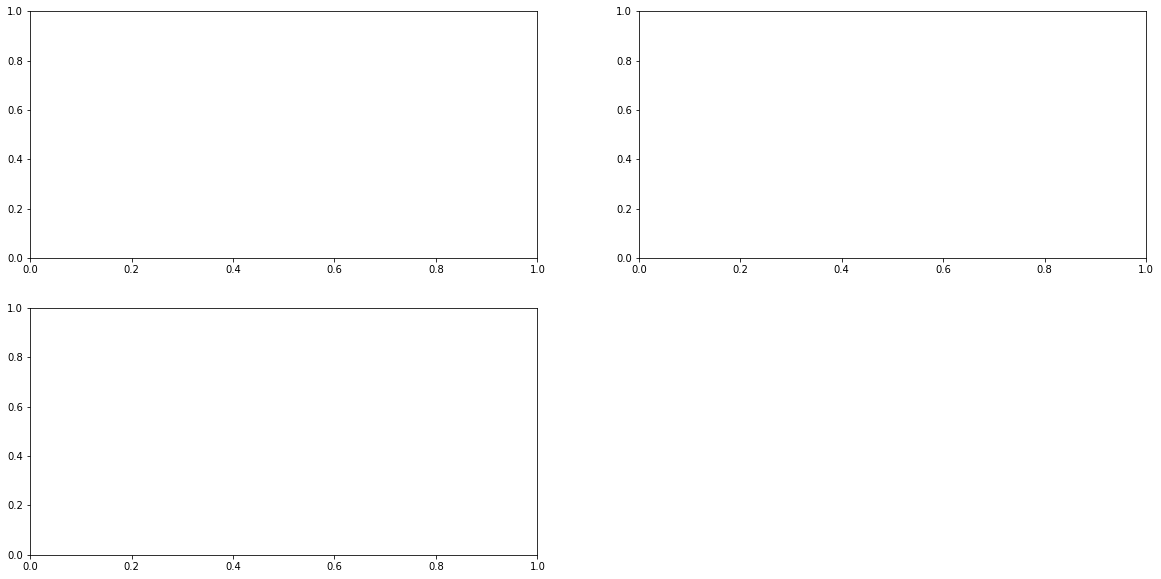

In [48]:
fig = plt.figure(figsize = (20,10))

ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 =  fig.add_subplot(223)

ax_data_raw = hashed_df.goes_letter.value_counts()

ax_x_val = ax_data_raw.keys()
ax_y_val = ax_data_raw.values

ax_x_val
ax_y_val
ax.bar(ax_x_val[1:], ax_y_val[1:])


In [295]:
out_repeat = []

for _, row in hashed_df.iterrows():

    if row['num_repeated'] == 2:

        # only keep 1 of the rows for this entry

        masked_df = ss_flares[ss_flares.peak_time == row['peak_time']]

        if row['hash_key'] == np.str('[]'):

            print(masked_df.id_team.unique())
            
    else:
        pass

['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['SolarSoft']
['Sola

In [100]:
# test_time = ss_flares[ss_flares.duplicated(subset='peak_time')].iloc[392].peak_time

# compare_df = ss_flares[ss_flares.peak_time == test_time].iloc[1].compare(ss_flares[ss_flares.peak_time == test_time].iloc[0]).reset_index()

#lets drop all with same peaktime and no difference.
repeated_hek_flares_out_list = []
repeated_hek_flares_out_check = []
hash_list = []
for repeated_peaktime in ss_flares[ss_flares.duplicated(subset='peak_time')].peak_time:

    masked_df = ss_flares[ss_flares.peak_time == repeated_peaktime]

    if len(masked_df) == 2:

        compare_df = masked_df.iloc[1].compare(masked_df.iloc[0]).reset_index().rename(columns={'index':'metadata'})

        # hashlib.sha256(url.encode('utf-8')).hexdigest()

        compare_df['hash_meta'] = [hashlib.sha256(np.str(compare_df.metadata.to_list()).encode('utf-8')).hexdigest() for _ in compare_df.metadata]

        # print([hashlib.sha256(np.str(compare_df.metadata.to_list()).encode('utf-8')).hexdigest() for _ in compare_df.metadata][0])

        # print(compare_df.iloc[0].hash_meta)

        if len(compare_df) == 0:

            this_hash = hashlib.sha256(np.str([]).encode('utf-8')).hexdigest()
        else:
            this_hash = compare_df.hash_meta.iloc[0]

        # repeated_hek_flares_out_check.append(compare_df)

        if this_hash == '4f53cda18c2baa0c0354bb5f9a3ecbe5ed12ab4d8e11ba873c2f11161202b945':

            repeated_hek_flares_out_list.append(masked_df.iloc[0])

            # print(masked_df.telescope_used.unique())

        
        if this_hash not in hash_list:

            # print(this_hash)
            hash_list.append(this_hash)

            repeated_hek_flares_out_check.append({'repeated_peaktime': repeated_peaktime, 'metadata': compare_df.metadata.to_list(), 'hash_meta':this_hash })



            # print(np.sum([this_hash == '4f53cda18c2baa0c0354bb5f9a3ecbe5ed12ab4d8e11ba873c2f11161202b945' for this_hash in compare_df.hash_meta]))

    #         # if compare_df.hash_meta.iloc[0] == '4f53cda18c2baa0c0354bb5f9a3ecbe5ed12ab4d8e11ba873c2f11161202b945': # hash for there is no difference 

    #         #     repeated_hek_flares_out_list.append(masked_df.iloc[0].to_dict('records'))
    #         # else:
    #         #     pass
    #             # repeated_hek_flares_out_list.append(masked_df.to_dict('records'))
    #     except:
    #         print(compare_df)





In [101]:
len(hash_list)

52

In [102]:
pd.DataFrame(repeated_hek_flares_out_list).id_team.value_counts()

SolarSoft    160
Name: id_team, dtype: int64

In [103]:
compare_df = masked_df.iloc[1].compare(masked_df.iloc[0]).reset_index().rename(columns={'index':'metadata'})
compare_df

,metadata,self,other
0,start_time,2020-11-29 00:59:00+00:00,2020-11-29 00:50:00+00:00
1,end_time,2020-11-29 02:43:00+00:00,2020-11-29 01:48:00+00:00
2,hgc_x,-20.60839,-20.52602
3,hpc_x,-240.351006,-240.350736
4,hpc_y,-318.970812,-318.982734


In [104]:
[hashlib.sha256(np.str(compare_df.metadata.to_list()).encode('utf-8')).hexdigest() for _ in compare_df.metadata]

['64059ebac571e2b384bc31d81bd5010434d57f455eab1ac6fc118cb89fa2d6af',
 '64059ebac571e2b384bc31d81bd5010434d57f455eab1ac6fc118cb89fa2d6af',
 '64059ebac571e2b384bc31d81bd5010434d57f455eab1ac6fc118cb89fa2d6af',
 '64059ebac571e2b384bc31d81bd5010434d57f455eab1ac6fc118cb89fa2d6af',
 '64059ebac571e2b384bc31d81bd5010434d57f455eab1ac6fc118cb89fa2d6af']

In [105]:
solar_soft_repeated_meta_data = pd.DataFrame(repeated_hek_flares_out_list)

In [106]:
np.str(compare_df.metadata.to_list())

"['start_time', 'end_time', 'hgc_x', 'hpc_x', 'hpc_y']"

In [107]:
solar_soft_repeated_meta_data = pd.DataFrame(repeated_hek_flares_out_list)

solar_soft_repeated_meta_data

,event_date,start_time,peak_time,end_time,goes_class,goes_letter,goes_number,AR_num,hgs_x,hgs_y,...,hgc_y,hpc_x,hpc_y,event_type,telescope_used,id_institute,id_team,search_instrument,search_channel,noposition
2931,2011-01-24,2011-01-24 05:56:00+00:00,2011-01-24 06:15:00+00:00,2011-01-24 06:32:00+00:00,C1.4,C,1.4,1149.0,38.0,17.0,...,17.0,575.557944,353.606472,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
3009,2011-01-27,2011-01-27 11:53:00+00:00,2011-01-27 12:01:00+00:00,2011-01-27 12:05:00+00:00,C1.2,C,1.2,0.0,87.0,12.0,...,12.0,951.414780,206.433108,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
3617,2011-02-14,2011-02-14 19:23:00+00:00,2011-02-14 19:30:00+00:00,2011-02-14 19:36:00+00:00,C6.6,C,6.6,0.0,4.0,-20.0,...,-20.0,63.945600,-222.975000,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
5193,2011-03-07,2011-03-07 07:59:00+00:00,2011-03-07 08:07:00+00:00,2011-03-07 08:15:00+00:00,M1.4,M,1.4,1164.0,46.0,27.0,...,27.0,621.052380,512.074656,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
5230,2011-03-07,2011-03-07 10:16:00+00:00,2011-03-07 10:20:00+00:00,2011-03-07 10:27:00+00:00,C4.9,C,4.9,1164.0,47.0,27.0,...,27.0,631.374000,510.655200,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114655,2017-02-09,2017-02-09 06:55:00+00:00,2017-02-09 07:02:00+00:00,2017-02-09 07:04:00+00:00,C1.1,C,1.1,2634.0,-22.0,12.0,...,12.0,-357.626436,302.600556,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
116404,2017-06-02,2017-06-02 17:50:00+00:00,2017-06-02 17:57:00+00:00,2017-06-02 18:01:00+00:00,C8.0,C,8.0,2661.0,-63.0,4.0,...,4.0,-842.117460,69.512706,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
117791,2017-08-20,2017-08-20 07:45:00+00:00,2017-08-20 07:50:00+00:00,2017-08-20 07:54:00+00:00,C2.9,C,2.9,2671.0,-1.0,10.0,...,10.0,-16.364321,51.957186,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
118220,2017-08-30,2017-08-30 18:38:00+00:00,2017-08-30 18:45:00+00:00,2017-08-30 18:50:00+00:00,C5.2,C,5.2,2674.0,-72.0,14.0,...,14.0,-877.914240,192.743952,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0


In [108]:
solar_soft_repeated_meta_data

,event_date,start_time,peak_time,end_time,goes_class,goes_letter,goes_number,AR_num,hgs_x,hgs_y,...,hgc_y,hpc_x,hpc_y,event_type,telescope_used,id_institute,id_team,search_instrument,search_channel,noposition
2931,2011-01-24,2011-01-24 05:56:00+00:00,2011-01-24 06:15:00+00:00,2011-01-24 06:32:00+00:00,C1.4,C,1.4,1149.0,38.0,17.0,...,17.0,575.557944,353.606472,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
3009,2011-01-27,2011-01-27 11:53:00+00:00,2011-01-27 12:01:00+00:00,2011-01-27 12:05:00+00:00,C1.2,C,1.2,0.0,87.0,12.0,...,12.0,951.414780,206.433108,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
3617,2011-02-14,2011-02-14 19:23:00+00:00,2011-02-14 19:30:00+00:00,2011-02-14 19:36:00+00:00,C6.6,C,6.6,0.0,4.0,-20.0,...,-20.0,63.945600,-222.975000,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
5193,2011-03-07,2011-03-07 07:59:00+00:00,2011-03-07 08:07:00+00:00,2011-03-07 08:15:00+00:00,M1.4,M,1.4,1164.0,46.0,27.0,...,27.0,621.052380,512.074656,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
5230,2011-03-07,2011-03-07 10:16:00+00:00,2011-03-07 10:20:00+00:00,2011-03-07 10:27:00+00:00,C4.9,C,4.9,1164.0,47.0,27.0,...,27.0,631.374000,510.655200,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114655,2017-02-09,2017-02-09 06:55:00+00:00,2017-02-09 07:02:00+00:00,2017-02-09 07:04:00+00:00,C1.1,C,1.1,2634.0,-22.0,12.0,...,12.0,-357.626436,302.600556,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
116404,2017-06-02,2017-06-02 17:50:00+00:00,2017-06-02 17:57:00+00:00,2017-06-02 18:01:00+00:00,C8.0,C,8.0,2661.0,-63.0,4.0,...,4.0,-842.117460,69.512706,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
117791,2017-08-20,2017-08-20 07:45:00+00:00,2017-08-20 07:50:00+00:00,2017-08-20 07:54:00+00:00,C2.9,C,2.9,2671.0,-1.0,10.0,...,10.0,-16.364321,51.957186,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0
118220,2017-08-30,2017-08-30 18:38:00+00:00,2017-08-30 18:45:00+00:00,2017-08-30 18:50:00+00:00,C5.2,C,5.2,2674.0,-72.0,14.0,...,14.0,-877.914240,192.743952,FL,SDO,LMSAL,SolarSoft,AIA,"131,171,193,211,304",0


In [109]:
keys, values = solar_soft_repeated_meta_data.hash_meta.value_counts().keys(),solar_soft_repeated_meta_data.hash_meta.value_counts().values



AttributeError: 'DataFrame' object has no attribute 'hash_meta'

In [110]:
compare_df
# compare_df.reset_index()


,metadata,self,other
0,start_time,2020-11-29 00:59:00+00:00,2020-11-29 00:50:00+00:00
1,end_time,2020-11-29 02:43:00+00:00,2020-11-29 01:48:00+00:00
2,hgc_x,-20.60839,-20.52602
3,hpc_x,-240.351006,-240.350736
4,hpc_y,-318.970812,-318.982734


In [111]:
# compare_df = ss_flares[ss_flares.peak_time == out_date].iloc[1].compare(ss_flares[ss_flares.peak_time == out_date].iloc[0])
# compare_df

In [112]:
g_flares = hek_flares[(hek_flares.id_team =='SWPC') & (hek_flares.goes_letter >= 'C')]
g_flares.goes_letter.value_counts()

C    7603
M     724
X      49
Name: goes_letter, dtype: int64

In [113]:
g_flares[g_flares.duplicated(subset='peak_time')].goes_letter.value_counts()

C    18
M     5
Name: goes_letter, dtype: int64

In [114]:
g_flares[g_flares.duplicated(subset='peak_time')].goes_letter.value_counts()

test_time2 = g_flares[g_flares.duplicated(subset='peak_time')].iloc[2].peak_time

g_flares[g_flares.peak_time == test_time2].iloc[1].compare(g_flares[g_flares.peak_time == test_time2].iloc[0])

,self,other
start_time,2012-09-29 07:50:00+00:00,2012-09-29 06:17:00+00:00
end_time,2012-09-29 07:56:00+00:00,2012-09-29 07:59:00+00:00
AR_num,11577.0,11575.0
hgs_x,66.0,45.0
hgs_y,9.0,6.0
hgs_bbox_poly,"[[65.5, 8.5], [66.5, 8.5], [66.5, 9.5], [65.5,...","[[44.5, 5.5], [45.5, 5.5], [45.5, 6.5], [44.5,..."
hgc_x,-172.09776,167.7545
hgc_y,9.0,6.0
hgc_bbox_poly,"[[-172.59776, 8.5], [-171.59776, 8.5], [-171.5...","[[167.2545, 5.5], [168.2545, 5.5], [168.2545, ..."
hpc_x,865.566,675.516


In [115]:
ss_flares = hek_flares[(hek_flares.id_team =='SolarSoft') & (hek_flares.goes_letter >= 'C')]
ss_flares.goes_letter.value_counts()

C    8198
M     788
X      52
Name: goes_letter, dtype: int64

In [116]:
flare_class_dict_query = {'A': 1e-8, 'B': 1e-7, 'C': 1e-6, 'M': 1e-5, 'X': 1e-4}
teams = {'ALEXIS': 1, 'SWPC': 2, 'SolarSoft':4}  
# tuples are (ALEXIS, SWPC, solar_soft)    
id_dict = {'7':(1,1,1), '6': (0,1,1), '5': (1,0,1),'4': (0,0,1),'3': (1,1,0),'2': (0,1,0),'1': (1,0,0)}

In [170]:
goes_flares = hek_flares[(hek_flares['id_team'] == 'SWPC') & (hek_flares['goes_class'] > 'C')].drop_duplicates().reset_index(drop= True)

solarsoft_flares = hek_flares[(hek_flares['id_team'] == 'SolarSoft') & (hek_flares['goes_class'] > 'C')].drop_duplicates().reset_index(drop= True)

zero_cross = merged_zerocross_df[(merged_zerocross_df['resampled_value'] > flare_class_dict_query['C'])].reset_index(drop= True)


TypeError: unhashable type: 'list'

In [173]:
solarsoft_flares.drop_duplicates()

TypeError: unhashable type: 'list'

In [172]:
solarsoft_flares.drop_duplicates()

TypeError: unhashable type: 'list'

In [120]:
#define our zero crossing df

our_flares = zero_cross[['zerocross_date_time']]

our_flares['id_team'] = 'ALEXIS'

only_duplicated_zero = our_flares[(our_flares.duplicated())]

zero_flares = our_flares.rename(columns = {'zerocross_date_time': 'peak_time'})

<ipython-input-120-531287107d90>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  our_flares['id_team'] = 'ALEXIS'


In [121]:
#define our zero crossing df

our_flares = zero_cross[['zerocross_date_time']]

our_flares['id_team'] = 'ALEXIS'

only_duplicated_zero = our_flares[(our_flares.duplicated())]

zero_flares = our_flares.rename(columns = {'zerocross_date_time': 'peak_time'})
# define SWPC Flares

goes_flares = pd.DataFrame(goes_flares.peak_time, columns = ['peak_time'])

goes_flares['id_team'] = 'SWPC'

In [122]:
#define our zero crossing df

our_flares = zero_cross[['zerocross_date_time']]

our_flares['id_team'] = 'ALEXIS'

only_duplicated_zero = our_flares[(our_flares.duplicated())]

zero_flares = our_flares.rename(columns = {'zerocross_date_time': 'peak_time'})
# define SWPC Flares

goes_flares = pd.DataFrame(goes_flares.peak_time, columns = ['peak_time'])

goes_flares['id_team'] = 'SWPC'

# define solarsoft flares

solarsoft_flares = pd.DataFrame(solarsoft_flares.peak_time, columns = ['peak_time'])

solarsoft_flares['id_team'] = 'SolarSoft'


all_flares_not_masked = pd.concat([zero_flares , goes_flares,  solarsoft_flares], ignore_index=True)

date_limit_low, date_limit_high = pd.Timestamp('2010/5/1T00:00:00', tz = 'utc'),pd.Timestamp('2020/3/4T00:00:00', tz = 'utc')

all_flares = all_flares_not_masked[(all_flares_not_masked.peak_time >= date_limit_low) & (all_flares_not_masked.peak_time <= date_limit_high)].sort_values(by = 'peak_time').reset_index(drop = True)

In [123]:
all_flares_not_masked = pd.concat([zero_flares , goes_flares,  solarsoft_flares], ignore_index=True)

date_limit_low, date_limit_high = pd.Timestamp('2010/5/1T00:00:00', tz = 'utc'),pd.Timestamp('2020/3/4T00:00:00', tz = 'utc')

all_flares = all_flares_not_masked[(all_flares_not_masked.peak_time >= date_limit_low) & (all_flares_not_masked.peak_time <= date_limit_high)].sort_values(by = 'peak_time').reset_index(drop = True)

In [124]:
minutes_per_agg = 10

j = 0 # grab first datetime in the list
flares_list = [] # keep track of info from loop

while j < len(all_flares.peak_time):
    
    datetime = all_flares.peak_time.iloc[j] # grab j-th datetime
        
    fwd = datetime + timedelta(minutes = minutes_per_agg) # choose fwd time range
     
    mask = all_flares[(all_flares.peak_time < fwd) & (all_flares.peak_time >= datetime)] # return df with all entries from current datetime to fwd time
    
    this_flare_datetime_list = []
    
    this_flare_identification = []
    
    for group in teams: 
        
        group_mask = mask[(mask.id_team) == group] #filter for all elements of mask that are returned by each individual group
        
        number_of_entries = len(group_mask)
        
        if number_of_entries != 0:
        
            mean_datetime = np.mean(group_mask.peak_time)
            
            this_flare_datetime_list.append({'datetime': mean_datetime})
            
            this_flare_identification.append(teams[group])
                   
        
    sum_of_ids = np.sum(this_flare_identification)
    
    flare_id_tuple = id_dict[str(sum_of_ids)]
    
    datetime_df = pd.DataFrame(this_flare_datetime_list)
    
    merged_datetime = np.mean(datetime_df.datetime)
            
    flares_list.append({'merged_datetime': merged_datetime,
                        'id_tuple': flare_id_tuple})
    
    k = len(mask) # go k amount fwd in the list of datetimes

    j = j + k

In [125]:
flare_list_df = pd.DataFrame(flares_list)
flare_list_df

,merged_datetime,id_tuple
0,2010-05-01 01:39:00.046000128+00:00,"(1, 1, 1)"
1,2010-05-04 16:29:20.046000128+00:00,"(1, 1, 1)"
2,2010-05-05 07:15:40.046000128+00:00,"(1, 1, 1)"
3,2010-05-05 11:52:40.046000128+00:00,"(1, 1, 1)"
4,2010-05-05 17:19:40.046000128+00:00,"(1, 1, 1)"
...,...,...
38662,2019-05-07 10:47:39.833166592+00:00,"(1, 1, 1)"
38663,2019-05-07 11:26:59.499500032+00:00,"(1, 0, 0)"
38664,2019-05-07 11:56:19.833166592+00:00,"(1, 1, 1)"
38665,2019-05-09 05:50:59.833166592+00:00,"(1, 1, 1)"


In [126]:
flare_list_df = pd.DataFrame(flares_list)
flare_list_df

plot_this = []
for name,group in pd.DataFrame(flares_list).groupby('id_tuple'):
    
    plot_this.append({'id_tuple': name, 
                     'counts': len(group)})
    

stat_df = pd.DataFrame(plot_this)

stat_df

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111)


# Example data
id_tuple = stat_df.id_tuple.to_list()
y_pos = np.arange(len(id_tuple))
counts = stat_df.counts.to_list()
# error = np.random.rand(len(people))



hbars = ax.barh(y_pos, counts, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(id_tuple)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('counts')
ax.set_ylabel('id_tuple == (jonas_lab, SWPC, solarsoft)')
ax.set_title('id_tuple == (jonas_lab, SWPC, solarsoft) @ {} minute fwd time'.format(minutes_per_agg))

for bar in hbars:
    print(bar.get_y())
    ax.text(bar.get_width(), bar.get_y(), s = bar.get_width(), va = 'center')

ax.set_xscale('log')

In [127]:
stat_df = pd.DataFrame(plot_this)

stat_df


,id_tuple,counts
0,"(0, 0, 1)",60
1,"(0, 1, 0)",36
2,"(0, 1, 1)",268
3,"(1, 0, 0)",29982
4,"(1, 0, 1)",378
5,"(1, 1, 0)",555
6,"(1, 1, 1)",7388


In [128]:
np.sum(stat_df.counts) - np.sum([55,57,248,30028,337,1788,6153])

1

In [129]:
7388+555+378



8321

-0.4
0.6
1.6
2.6
3.6
4.6
5.6


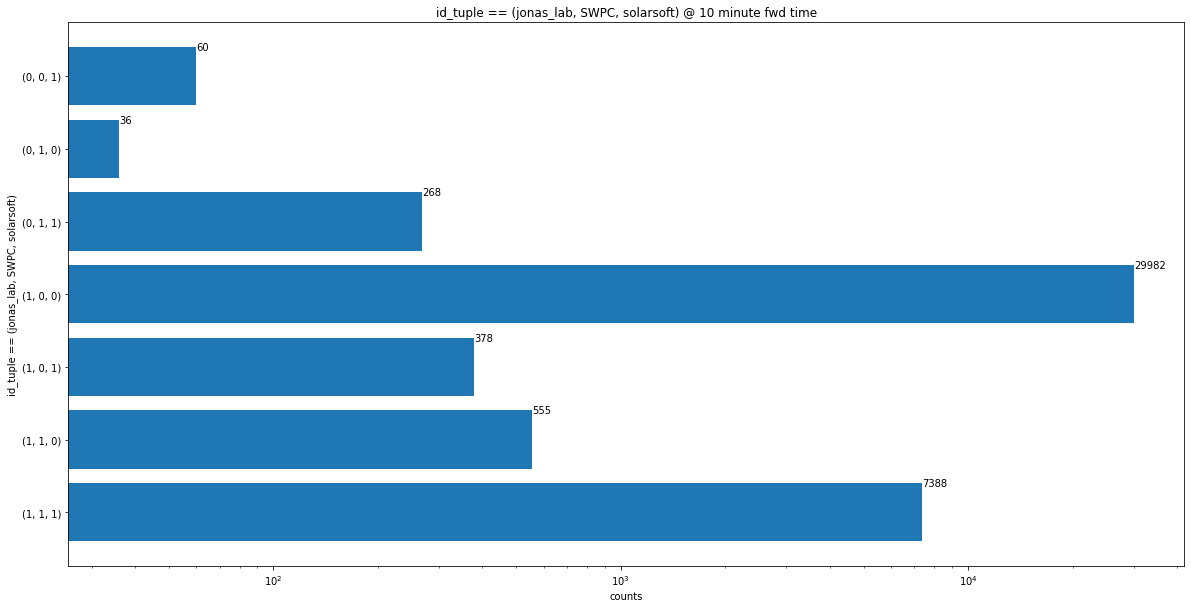

In [130]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111)


# Example data
id_tuple = stat_df.id_tuple.to_list()
y_pos = np.arange(len(id_tuple))
counts = stat_df.counts.to_list()
# error = np.random.rand(len(people))



hbars = ax.barh(y_pos, counts, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(id_tuple)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('counts')
ax.set_ylabel('id_tuple == (jonas_lab, SWPC, solarsoft)')
ax.set_title('id_tuple == (jonas_lab, SWPC, solarsoft) @ {} minute fwd time'.format(minutes_per_agg))

for bar in hbars:
    print(bar.get_y())
    ax.text(bar.get_width(), bar.get_y(), s = bar.get_width(), va = 'center')

ax.set_xscale('log')